In [1]:

import pandas as pd
import numpy as np
from scipy.stats.stats import pearsonr  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from datetime import datetime
import plotly.plotly as py
import matplotlib.pyplot as plt
import json
import branca.colormap as cm
import folium
import seaborn as sns


## Carga de CSVs

## A continuacion se realiza la carga de archivos a los dataframe correspondientes.

In [2]:
dfEstaciones =pd.read_csv('../CSVs/station.csv', thousands=',', low_memory=False)
dfClima=pd.read_csv('../CSVs/weather.csv', thousands=',', low_memory=False)
dfViajes = pd.read_csv('../CSVs/trip.csv', thousands=',', low_memory=False)
#Df creado por nuestro grupo con la informacion que queriamos analizar de Status.csv
dfTableID_DocksAvailable = pd.read_csv('../CSVs/tabla_id_dockAvailable.csv')

   # Filtrado de dfEstaciones

## El objetivo es simplemente ver la estructura del dataframe y saber que informacion nos puede brindar.

In [3]:
print (dfEstaciones.shape) 

(70, 7)


In [4]:
dfEstaciones

id                                           name        lat        long  \
0    2              San Jose Diridon Caltrain Station  37.329732 -121.901782   
1    3                          San Jose Civic Center  37.330698 -121.888979   
2    4                         Santa Clara at Almaden  37.333988 -121.894902   
3    5                               Adobe on Almaden  37.331415 -121.893200   
4    6                               San Pedro Square  37.336721 -121.894074   
5    7                           Paseo de San Antonio  37.333798 -121.886943   
6    8                            San Salvador at 1st  37.330165 -121.885831   
7    9                                      Japantown  37.348742 -121.894715   
8   10                             San Jose City Hall  37.337391 -121.886995   
9   11                                    MLK Library  37.335885 -121.885660   
10  12                         SJSU 4th at San Carlos  37.332808 -121.883891   
11  13                                  St James Park  37.339301 -121.889937   
12  14                       Arena Green / SAP Center  37.332692 -121.900084   
13  16                     SJSU - San Salvador at 9th  37.333955 -121.877349   
14  21                              Franklin at Maple  37.481758 -122.226904   
15  22                  Redwood City Caltrain Station  37.486078 -122.232089   
16  23                        San Mateo County Center  37.487616 -122.229951   
17  24                    Redwood City Public Library  37.484219 -122.227424   
18  25                       Stanford in Redwood City  37.485370 -122.203288   
19  26                    Redwood City Medical Center  37.487682 -122.223492   
20  27                        Mountain View City Hall  37.389218 -122.081896   
21  28                 Mountain View Caltrain Station  37.394358 -122.076713   
22  29                   San Antonio Caltrain Station  37.406940 -122.106758   
23  30                           Evelyn Park and Ride  37.390277 -122.066553   
24  31                    San Antonio Shopping Center  37.400443 -122.108338   
25  32               Castro Street and El Camino Real  37.385956 -122.083678   
26  33          Rengstorff Avenue / California Street  37.400241 -122.099076   
27  34                     Palo Alto Caltrain Station  37.443988 -122.164759   
28  35                         University and Emerson  37.444521 -122.163093   
29  36                California Ave Caltrain Station  37.429082 -122.142805   
..  ..                                            ...        ...         ...   
40  51                          Embarcadero at Folsom  37.791464 -122.391034   
41  39                             Powell Street BART  37.783871 -122.408433   
42  54                          Embarcadero at Bryant  37.787152 -122.388013   
43  55  Temporary Transbay Terminal (Howard at Beale)  37.789756 -122.394643   
44  56                                Beale at Market  37.792251 -122.397086   
45  57                                  5th at Howard  37.781752 -122.405127   
46  58                        San Francisco City Hall  37.778650 -122.418235   
47  59                            Golden Gate at Polk  37.781332 -122.418603   
48  60                         Embarcadero at Sansome  37.804770 -122.403234   
49  61                                2nd at Townsend  37.780526 -122.390288   
50  62                                  2nd at Folsom  37.785299 -122.396236   
51  63                                  Howard at 2nd  37.786978 -122.398108   
52  64                              2nd at South Park  37.782259 -122.392738   
53  65                                Townsend at 7th  37.771058 -122.402717   
54  66                       South Van Ness at Market  37.774814 -122.418954   
55  67                                 Market at 10th  37.776619 -122.417385   
56  68  Yerba Buena Center of the Arts (3rd @ Howard)  37.784878 -122.401014   
57  69        San Francisco Caltrain 2 (330 Townsend)  37.776600 -122.395470   
58  

In [5]:
dfEstaciones.dtypes

id                     int64
name                  object
lat                  float64
long                 float64
dock_count             int64
city                  object
installation_date     object
dtype: object

In [6]:
# No tenemos nullos
dfEstaciones.isnull().sum()

id                   0
name                 0
lat                  0
long                 0
dock_count           0
city                 0
installation_date    0
dtype: int64

In [7]:
#Pasamos el campo installation_date al tipo datetime
dfEstaciones.installation_date = pd.to_datetime(dfEstaciones.installation_date, format = "%m/%d/%Y").dt.date

#Probamos si funciona correctamente
print (dfEstaciones.installation_date.min())
print (dfEstaciones.installation_date.max())

2013-08-05
2014-04-09


# Filtrado de df Status.csv

## status.csv era un archivo de 2GB el cual fue reducido a una tabla con la informacion que ibamos a utilizar, esta contiene la estaciones agrupadas por ID junto con los docks_available en promedio. 
## El objetivo es obtener un porcentaje, el cual represanta la utilidad de esa estacion, es decir que tanto se utilizan sus docks en relacion a los disponibles.

In [8]:
dfTableID_DocksAvailable.head()

station_id  docks_available
0           2        13.761535
1           3         6.527884
2           4         5.685249
3           5        10.868663
4           6         7.383773

In [9]:
dfEstaciones.head()

id                               name        lat        long  dock_count  \
0   2  San Jose Diridon Caltrain Station  37.329732 -121.901782          27   
1   3              San Jose Civic Center  37.330698 -121.888979          15   
2   4             Santa Clara at Almaden  37.333988 -121.894902          11   
3   5                   Adobe on Almaden  37.331415 -121.893200          19   
4   6                   San Pedro Square  37.336721 -121.894074          15   

       city installation_date  
0  San Jose        2013-08-06  
1  San Jose        2013-08-05  
2  San Jose        2013-08-06  
3  San Jose        2013-08-05  
4  San Jose        2013-08-07

In [10]:
#Realizamos merge de dataframe 'dfEstaciones' con 'dfTableID_DocksAvailable' por ID de estacion
dfusagePercentagePerStation = dfEstaciones.merge(dfTableID_DocksAvailable, left_on='id', right_on='station_id').drop('station_id', 1)
dfusagePercentagePerStation

id                                           name        lat        long  \
0    2              San Jose Diridon Caltrain Station  37.329732 -121.901782   
1    3                          San Jose Civic Center  37.330698 -121.888979   
2    4                         Santa Clara at Almaden  37.333988 -121.894902   
3    5                               Adobe on Almaden  37.331415 -121.893200   
4    6                               San Pedro Square  37.336721 -121.894074   
5    7                           Paseo de San Antonio  37.333798 -121.886943   
6    8                            San Salvador at 1st  37.330165 -121.885831   
7    9                                      Japantown  37.348742 -121.894715   
8   10                             San Jose City Hall  37.337391 -121.886995   
9   11                                    MLK Library  37.335885 -121.885660   
10  12                         SJSU 4th at San Carlos  37.332808 -121.883891   
11  13                                  St James Park  37.339301 -121.889937   
12  14                       Arena Green / SAP Center  37.332692 -121.900084   
13  16                     SJSU - San Salvador at 9th  37.333955 -121.877349   
14  21                              Franklin at Maple  37.481758 -122.226904   
15  22                  Redwood City Caltrain Station  37.486078 -122.232089   
16  23                        San Mateo County Center  37.487616 -122.229951   
17  24                    Redwood City Public Library  37.484219 -122.227424   
18  25                       Stanford in Redwood City  37.485370 -122.203288   
19  26                    Redwood City Medical Center  37.487682 -122.223492   
20  27                        Mountain View City Hall  37.389218 -122.081896   
21  28                 Mountain View Caltrain Station  37.394358 -122.076713   
22  29                   San Antonio Caltrain Station  37.406940 -122.106758   
23  30                           Evelyn Park and Ride  37.390277 -122.066553   
24  31                    San Antonio Shopping Center  37.400443 -122.108338   
25  32               Castro Street and El Camino Real  37.385956 -122.083678   
26  33          Rengstorff Avenue / California Street  37.400241 -122.099076   
27  34                     Palo Alto Caltrain Station  37.443988 -122.164759   
28  35                         University and Emerson  37.444521 -122.163093   
29  36                California Ave Caltrain Station  37.429082 -122.142805   
..  ..                                            ...        ...         ...   
40  51                          Embarcadero at Folsom  37.791464 -122.391034   
41  39                             Powell Street BART  37.783871 -122.408433   
42  54                          Embarcadero at Bryant  37.787152 -122.388013   
43  55  Temporary Transbay Terminal (Howard at Beale)  37.789756 -122.394643   
44  56                                Beale at Market  37.792251 -122.397086   
45  57                                  5th at Howard  37.781752 -122.405127   
46  58                        San Francisco City Hall  37.778650 -122.418235   
47  59                            Golden Gate at Polk  37.781332 -122.418603   
48  60                         Embarcadero at Sansome  37.804770 -122.403234   
49  61                                2nd at Townsend  37.780526 -122.390288   
50  62                                  2nd at Folsom  37.785299 -122.396236   
51  63                                  Howard at 2nd  37.786978 -122.398108   
52  64                              2nd at South Park  37.782259 -122.392738   
53  65                                Townsend at 7th  37.771058 -122.402717   
54  66                       South Van Ness at Market  37.774814 -122.418954   
55  67                                 Market at 10th  37.776619 -122.417385   
56  68  Yerba Buena Center of the Arts (3rd @ Howard)  37.784878 -122.401014   
57  69        San Francisco Caltrain 2 (330 Townsend)  37.776600 -122.395470   
58  

In [11]:
#Le damos un nombre mas significado al feature
dfusagePercentagePerStation = dfusagePercentagePerStation.rename(columns={'docks_available': 'mean_of_docks_available'})
dfusagePercentagePerStation

id                                           name        lat        long  \
0    2              San Jose Diridon Caltrain Station  37.329732 -121.901782   
1    3                          San Jose Civic Center  37.330698 -121.888979   
2    4                         Santa Clara at Almaden  37.333988 -121.894902   
3    5                               Adobe on Almaden  37.331415 -121.893200   
4    6                               San Pedro Square  37.336721 -121.894074   
5    7                           Paseo de San Antonio  37.333798 -121.886943   
6    8                            San Salvador at 1st  37.330165 -121.885831   
7    9                                      Japantown  37.348742 -121.894715   
8   10                             San Jose City Hall  37.337391 -121.886995   
9   11                                    MLK Library  37.335885 -121.885660   
10  12                         SJSU 4th at San Carlos  37.332808 -121.883891   
11  13                                  St James Park  37.339301 -121.889937   
12  14                       Arena Green / SAP Center  37.332692 -121.900084   
13  16                     SJSU - San Salvador at 9th  37.333955 -121.877349   
14  21                              Franklin at Maple  37.481758 -122.226904   
15  22                  Redwood City Caltrain Station  37.486078 -122.232089   
16  23                        San Mateo County Center  37.487616 -122.229951   
17  24                    Redwood City Public Library  37.484219 -122.227424   
18  25                       Stanford in Redwood City  37.485370 -122.203288   
19  26                    Redwood City Medical Center  37.487682 -122.223492   
20  27                        Mountain View City Hall  37.389218 -122.081896   
21  28                 Mountain View Caltrain Station  37.394358 -122.076713   
22  29                   San Antonio Caltrain Station  37.406940 -122.106758   
23  30                           Evelyn Park and Ride  37.390277 -122.066553   
24  31                    San Antonio Shopping Center  37.400443 -122.108338   
25  32               Castro Street and El Camino Real  37.385956 -122.083678   
26  33          Rengstorff Avenue / California Street  37.400241 -122.099076   
27  34                     Palo Alto Caltrain Station  37.443988 -122.164759   
28  35                         University and Emerson  37.444521 -122.163093   
29  36                California Ave Caltrain Station  37.429082 -122.142805   
..  ..                                            ...        ...         ...   
40  51                          Embarcadero at Folsom  37.791464 -122.391034   
41  39                             Powell Street BART  37.783871 -122.408433   
42  54                          Embarcadero at Bryant  37.787152 -122.388013   
43  55  Temporary Transbay Terminal (Howard at Beale)  37.789756 -122.394643   
44  56                                Beale at Market  37.792251 -122.397086   
45  57                                  5th at Howard  37.781752 -122.405127   
46  58                        San Francisco City Hall  37.778650 -122.418235   
47  59                            Golden Gate at Polk  37.781332 -122.418603   
48  60                         Embarcadero at Sansome  37.804770 -122.403234   
49  61                                2nd at Townsend  37.780526 -122.390288   
50  62                                  2nd at Folsom  37.785299 -122.396236   
51  63                                  Howard at 2nd  37.786978 -122.398108   
52  64                              2nd at South Park  37.782259 -122.392738   
53  65                                Townsend at 7th  37.771058 -122.402717   
54  66                       South Van Ness at Market  37.774814 -122.418954   
55  67                                 Market at 10th  37.776619 -122.417385   
56  68  Yerba Buena Center of the Arts (3rd @ Howard)  37.784878 -122.401014   
57  69        San Francisco Caltrain 2 (330 Townsend)  37.776600 -122.395470   
58  

In [12]:
#Obtenemos el porcentaje de utilidad de cada estacion
dfusagePercentagePerStation['docks_usage_percentage'] = dfusagePercentagePerStation.mean_of_docks_available/dfusagePercentagePerStation.dock_count
dfusagePercentagePerStation

id                                           name        lat        long  \
0    2              San Jose Diridon Caltrain Station  37.329732 -121.901782   
1    3                          San Jose Civic Center  37.330698 -121.888979   
2    4                         Santa Clara at Almaden  37.333988 -121.894902   
3    5                               Adobe on Almaden  37.331415 -121.893200   
4    6                               San Pedro Square  37.336721 -121.894074   
5    7                           Paseo de San Antonio  37.333798 -121.886943   
6    8                            San Salvador at 1st  37.330165 -121.885831   
7    9                                      Japantown  37.348742 -121.894715   
8   10                             San Jose City Hall  37.337391 -121.886995   
9   11                                    MLK Library  37.335885 -121.885660   
10  12                         SJSU 4th at San Carlos  37.332808 -121.883891   
11  13                                  St James Park  37.339301 -121.889937   
12  14                       Arena Green / SAP Center  37.332692 -121.900084   
13  16                     SJSU - San Salvador at 9th  37.333955 -121.877349   
14  21                              Franklin at Maple  37.481758 -122.226904   
15  22                  Redwood City Caltrain Station  37.486078 -122.232089   
16  23                        San Mateo County Center  37.487616 -122.229951   
17  24                    Redwood City Public Library  37.484219 -122.227424   
18  25                       Stanford in Redwood City  37.485370 -122.203288   
19  26                    Redwood City Medical Center  37.487682 -122.223492   
20  27                        Mountain View City Hall  37.389218 -122.081896   
21  28                 Mountain View Caltrain Station  37.394358 -122.076713   
22  29                   San Antonio Caltrain Station  37.406940 -122.106758   
23  30                           Evelyn Park and Ride  37.390277 -122.066553   
24  31                    San Antonio Shopping Center  37.400443 -122.108338   
25  32               Castro Street and El Camino Real  37.385956 -122.083678   
26  33          Rengstorff Avenue / California Street  37.400241 -122.099076   
27  34                     Palo Alto Caltrain Station  37.443988 -122.164759   
28  35                         University and Emerson  37.444521 -122.163093   
29  36                California Ave Caltrain Station  37.429082 -122.142805   
..  ..                                            ...        ...         ...   
40  51                          Embarcadero at Folsom  37.791464 -122.391034   
41  39                             Powell Street BART  37.783871 -122.408433   
42  54                          Embarcadero at Bryant  37.787152 -122.388013   
43  55  Temporary Transbay Terminal (Howard at Beale)  37.789756 -122.394643   
44  56                                Beale at Market  37.792251 -122.397086   
45  57                                  5th at Howard  37.781752 -122.405127   
46  58                        San Francisco City Hall  37.778650 -122.418235   
47  59                            Golden Gate at Polk  37.781332 -122.418603   
48  60                         Embarcadero at Sansome  37.804770 -122.403234   
49  61                                2nd at Townsend  37.780526 -122.390288   
50  62                                  2nd at Folsom  37.785299 -122.396236   
51  63                                  Howard at 2nd  37.786978 -122.398108   
52  64                              2nd at South Park  37.782259 -122.392738   
53  65                                Townsend at 7th  37.771058 -122.402717   
54  66                       South Van Ness at Market  37.774814 -122.418954   
55  67                                 Market at 10th  37.776619 -122.417385   
56  68  Yerba Buena Center of the Arts (3rd @ Howard)  37.784878 -122.401014   
57  69        San Francisco Caltrain 2 (330 Townsend)  37.776600 -122.395470   
58  

In [13]:
dfusagePercentagePerStation.to_csv('../CSVs//usagePercentagePerStation.csv')

In [14]:
dfusagePercentagePerStation.installation_date = pd.to_datetime(dfusagePercentagePerStation.installation_date, format = "%Y/%m/%d")


ValueError: time data datetime.date(2013, 8, 6) does not match format '%Y/%m/%d' (match)

# Filtrado de dfClima
## El objetivo es simplemente ver la estructura del dataframe y saber que informacion nos puede brindar.

In [16]:
dfClima

date  max_temperature_f  mean_temperature_f  min_temperature_f  \
0     8/29/2013                 74                  68                 61   
1     8/30/2013                 78                  69                 60   
2     8/31/2013                 71                  64                 57   
3      9/1/2013                 74                  66                 58   
4      9/2/2013                 75                  69                 62   
5      9/3/2013                 73                  67                 60   
6      9/4/2013                 74                  68                 61   
7      9/5/2013                 72                  66                 60   
8      9/6/2013                 85                  71                 56   
9      9/7/2013                 88                  73                 58   
10     9/8/2013                 74                  65                 56   
11     9/9/2013                 76                  66                 55   
12    9/10/2013                 74                  66                 57   
13    9/11/2013                 74                  68                 62   
14    9/12/2013                 71                  65                 59   
15    9/13/2013                 66                  62                 57   
16    9/14/2013                 66                  62                 57   
17    9/15/2013                 73                  66                 58   
18    9/16/2013                 71                  65                 59   
19    9/17/2013                 68                  63                 57   
20    9/18/2013                 78                  66                 54   
21    9/19/2013                 80                  67                 54   
22    9/20/2013                 73                  65                 56   
23    9/21/2013                 68                  63                 58   
24    9/22/2013                 70                  63                 55   
25    9/23/2013                 78                  68                 57   
26    9/24/2013                 71                  65                 58   
27    9/25/2013                 67                  62                 56   
28    9/26/2013                 71                  62                 53   
29    9/27/2013                 78                  66                 54   
...         ...                ...                 ...                ...   
3635   8/2/2015                 76                  70                 63   
3636   8/3/2015                 77                  69                 61   
3637   8/4/2015                 76                  67                 58   
3638   8/5/2015                 79                  69                 58   
3639   8/6/2015                 78                  70                 61   
3640   8/7/2015                 83                  72                 60   
3641   8/8/2015                 78                  69                 60   
3642   8/9/2015                 78                  68                 57   
3643  8/10/2015                 80                  70                 60   
3644  8/11/2015                 82                  71                 60   
3645  8/12/2015                 81                  69                 57   
3646  8/13/2015                 80                  72                 64   
3647  8/14/2015                 79                  72                 64   
3648  8/15/2015                 93                  76                 59   
3649  8/16/2015                 97                  82                 66   
3650  8/17/2015                 91                  77                 63   
3651  8/18/2015                 81                  70                 58   
3652  8/19/2015                 77                  69                 61   
3653  8/20/2015                 75                  69                 62   
3654  8/21/2015                 79                  70                 60   
3655  8

In [17]:
dfClima.shape

(3665, 24)

In [18]:
#Vemos que contiene muchos nulos
dfClima.isnull().sum()

date                                 0
max_temperature_f                    4
mean_temperature_f                   4
min_temperature_f                    4
max_dew_point_f                     54
mean_dew_point_f                    54
min_dew_point_f                     54
max_humidity                        54
mean_humidity                       54
min_humidity                        54
max_sea_level_pressure_inches        1
mean_sea_level_pressure_inches       1
min_sea_level_pressure_inches        1
max_visibility_miles                13
mean_visibility_miles               13
min_visibility_miles                13
max_wind_Speed_mph                   1
mean_wind_speed_mph                  1
max_gust_speed_mph                 899
precipitation_inches                 1
cloud_cover                          1
events                            3143
wind_dir_degrees                     1
zip_code                             0
dtype: int64

In [19]:
#Pasamos a datetime
dfClima.date = pd.to_datetime(dfClima.date, format='%m/%d/%Y')

In [20]:
dfClima.head(10)

date  max_temperature_f  mean_temperature_f  min_temperature_f  \
0 2013-08-29                 74                  68                 61   
1 2013-08-30                 78                  69                 60   
2 2013-08-31                 71                  64                 57   
3 2013-09-01                 74                  66                 58   
4 2013-09-02                 75                  69                 62   
5 2013-09-03                 73                  67                 60   
6 2013-09-04                 74                  68                 61   
7 2013-09-05                 72                  66                 60   
8 2013-09-06                 85                  71                 56   
9 2013-09-07                 88                  73                 58   

   max_dew_point_f  mean_dew_point_f  min_dew_point_f  max_humidity  \
0               61                58               56            93   
1               61                58               56            90   
2               57                56               54            93   
3               60                56               53            87   
4               61                60               58            93   
5               59                56               51            84   
6               59                57               56            90   
7               57                56               54            90   
8               57                51               45            86   
9               64                54               46            86   

   mean_humidity  min_humidity   ...     mean_visibility_miles  \
0             75            57   ...                        10   
1             70            50   ...                        10   
2             75            57   ...                        10   
3             68            49   ...                        10   
4             77            61   ...                        10   
5             65            46   ...                        10   
6             72            53   ...                        10   
7             74            57   ...                        10   
8             58            29   ...                        10   
9             59            31   ...                        10   

   min_visibility_miles  max_wind_Speed_mph  mean_wind_speed_mph  \
0                    10                  23                   11   
1                     7                  29                   13   
2                    10                  26                   15   
3                    10                  25                   13   
4                     6                  23                   12   
5                    10                  24                   15   
6                    10                  29                   19   
7                    10                  31                   21   
8                    10                  24                    8   
9                    10                  21                    8   

   max_gust_speed_mph  precipitation_inches  cloud_cover  events  \
0                  28                     0            4     NaN   
1                  35                     0            2     NaN   
2                  31                     0            4     NaN   
3                  29                     0            4     NaN   
4                  30                     0            6     NaN   
5                  31                     0            2     NaN   
6                  35                     0            4     NaN   
7                  37                     0            3     NaN   
8                  28                     0            0     NaN   
9                  25                     0            1     NaN   

   wind_dir_degrees zip_code  
0               286    94107  
1               291    94107  
2               284    94107  
3               284    94107  
4               277    94107  


In [21]:
dfClima.events.unique()

array([nan, 'Fog', 'Rain', 'Fog-Rain', 'rain', 'Rain-Thunderstorm'], dtype=object)

In [22]:
#Limpio los datos bugeados, tenemos mucha informacion nula, la cual decidimos pasar a Normal
#Tambien corregi
dfClima.loc[dfClima.events == 'rain', 'events'] = "Rain"
dfClima.loc[dfClima.events.isnull(), 'events'] = "Normal"

In [23]:
# EL zip_code es el codigo postal para las 5 ciudades de la bahia
dfClima.zip_code.unique()

array([94107, 94063, 94301, 94041, 95113])

In [24]:
# Vemos cual de estos zip code tiene menos nulos
for zc in dfClima.zip_code.unique():
    print (dfClima[dfClima.zip_code == zc].isnull().sum())
    print ()

date                               0
max_temperature_f                  0
mean_temperature_f                 0
min_temperature_f                  0
max_dew_point_f                    0
mean_dew_point_f                   0
min_dew_point_f                    0
max_humidity                       0
mean_humidity                      0
min_humidity                       0
max_sea_level_pressure_inches      0
mean_sea_level_pressure_inches     0
min_sea_level_pressure_inches      0
max_visibility_miles               0
mean_visibility_miles              0
min_visibility_miles               0
max_wind_Speed_mph                 0
mean_wind_speed_mph                0
max_gust_speed_mph                13
precipitation_inches               0
cloud_cover                        0
events                             0
wind_dir_degrees                   0
zip_code                           0
dtype: int64
()
date                                0
max_temperature_f                   0
mean_temperature_f  

In [25]:
#Trabajamos con el zip_code == 94107, es el mas 'limpio' de nulos, dada la cercania de todas las ciudades 
#la informacion no puede ser muy cambiante entre estas, por lo cual consideramos valido filtrar por una en particular.
dfClimaLimpio = dfClima[dfClima.zip_code == 94107]
dfClimaLimpio.shape

(733, 24)

In [26]:
dfClimaLimpio.events

0                  Normal
1                  Normal
2                  Normal
3                  Normal
4                  Normal
5                  Normal
6                  Normal
7                  Normal
8                  Normal
9                  Normal
10                 Normal
11                 Normal
12                 Normal
13                 Normal
14                    Fog
15                 Normal
16                 Normal
17                 Normal
18                 Normal
19                 Normal
20                 Normal
21                 Normal
22                 Normal
23                   Rain
24                 Normal
25                 Normal
26                 Normal
27                 Normal
28                 Normal
29                 Normal
              ...        
2175               Normal
2176               Normal
2177               Normal
2178               Normal
2179    Rain-Thunderstorm
2180               Normal
2181               Normal
2182        

In [27]:
#Transformamos el feature events, en un nuevo dataframe el cual añadiremos a dfClimaLimpio
events = pd.get_dummies(dfClimaLimpio.events)
events

Fog  Fog-Rain  Normal  Rain  Rain-Thunderstorm
0       0         0       1     0                  0
1       0         0       1     0                  0
2       0         0       1     0                  0
3       0         0       1     0                  0
4       0         0       1     0                  0
5       0         0       1     0                  0
6       0         0       1     0                  0
7       0         0       1     0                  0
8       0         0       1     0                  0
9       0         0       1     0                  0
10      0         0       1     0                  0
11      0         0       1     0                  0
12      0         0       1     0                  0
13      0         0       1     0                  0
14      1         0       0     0                  0
15      0         0       1     0                  0
16      0         0       1     0                  0
17      0         0       1     0                  0
18      0         0       1     0                  0
19      0         0       1     0                  0
20      0         0       1     0                  0
21      0         0       1     0                  0
22      0         0       1     0                  0
23      0         0       0     1                  0
24      0         0       1     0                  0
25      0         0       1     0                  0
26      0         0       1     0                  0
27      0         0       1     0                  0
28      0         0       1     0                  0
29      0         0       1     0                  0
...   ...       ...     ...   ...                ...
2175    0         0       1     0                  0
2176    0         0       1     0                  0
2177    0         0       1     0                  0
2178    0         0       1     0                  0
2179    0         0       0     0                  1
2180    0         0       1     0                  0
2181    0         0       1     0                  0
2182    0         0       1     0                  0
2183    0         0       1     0                  0
2184    0         0       1     0                  0
2185    0         0       1     0                  0
2186    0         0       1     0                  0
2187    0         0       1     0                  0
2188    0         0       1     0                  0
2189    0         0       1     0                  0
2190    0         0       1     0                  0
2191    0         0       1     0                  0
2192    0         0       1     0                  0
2193    0         0       1     0                  0
2194    0         0       1     0                  0
2195    0         0       1     0                  0
2196    0         0       1     0                  0
2197    0         0       1     0                  0
2198    0         0       1     0                  0
2199    0         0       1     0                  0
2200    0         0       1     0                  0
2201    0         0       1     0                  0
2202    0         0       0     1                  0
2203    0         0       1     0                  0
2204    0         0       1     0                  0

[733 rows x 5 columns]

In [28]:
#Mergeo los 2 data frames, eventos con dfClimaLimpio
dfClimaLimpio = dfClimaLimpio.merge(events, left_index = True, right_index = True)
#Saco los features que no voy a usar
dfClimaLimpio = dfClimaLimpio.drop(['events','zip_code'],1)

In [29]:
#Todavia tenemos nulos
dfClimaLimpio.isnull().sum()

date                               0
max_temperature_f                  0
mean_temperature_f                 0
min_temperature_f                  0
max_dew_point_f                    0
mean_dew_point_f                   0
min_dew_point_f                    0
max_humidity                       0
mean_humidity                      0
min_humidity                       0
max_sea_level_pressure_inches      0
mean_sea_level_pressure_inches     0
min_sea_level_pressure_inches      0
max_visibility_miles               0
mean_visibility_miles              0
min_visibility_miles               0
max_wind_Speed_mph                 0
mean_wind_speed_mph                0
max_gust_speed_mph                13
precipitation_inches               0
cloud_cover                        0
wind_dir_degrees                   0
Fog                                0
Fog-Rain                           0
Normal                             0
Rain                               0
Rain-Thunderstorm                  0
d

In [30]:
#El campo max_gust_speed_mph no esta limpio todavia, lo trabajo
#Para cada valor de max_wind, busco la media de max_gust y la uso para rellenar los nulos.
dfClimaLimpio.loc[dfClimaLimpio.max_gust_speed_mph.isnull(), 'max_gust_speed_mph'] = \
                                dfClimaLimpio.groupby('max_wind_Speed_mph').\
                                max_gust_speed_mph.apply(lambda x: x.fillna(x.median()))

In [31]:
# Listo para usar
dfClimaLimpio.isnull().sum()

date                              0
max_temperature_f                 0
mean_temperature_f                0
min_temperature_f                 0
max_dew_point_f                   0
mean_dew_point_f                  0
min_dew_point_f                   0
max_humidity                      0
mean_humidity                     0
min_humidity                      0
max_sea_level_pressure_inches     0
mean_sea_level_pressure_inches    0
min_sea_level_pressure_inches     0
max_visibility_miles              0
mean_visibility_miles             0
min_visibility_miles              0
max_wind_Speed_mph                0
mean_wind_speed_mph               0
max_gust_speed_mph                0
precipitation_inches              0
cloud_cover                       0
wind_dir_degrees                  0
Fog                               0
Fog-Rain                          0
Normal                            0
Rain                              0
Rain-Thunderstorm                 0
dtype: int64

In [32]:
# el campo precipitation_inches lo deseamos de tipo numerico
dfClimaLimpio.dtypes

date                              datetime64[ns]
max_temperature_f                        float64
mean_temperature_f                       float64
min_temperature_f                        float64
max_dew_point_f                          float64
mean_dew_point_f                         float64
min_dew_point_f                          float64
max_humidity                             float64
mean_humidity                            float64
min_humidity                             float64
max_sea_level_pressure_inches            float64
mean_sea_level_pressure_inches           float64
min_sea_level_pressure_inches            float64
max_visibility_miles                     float64
mean_visibility_miles                    float64
min_visibility_miles                     float64
max_wind_Speed_mph                       float64
mean_wind_speed_mph                      float64
max_gust_speed_mph                       float64
precipitation_inches                      object
cloud_cover         

In [33]:
dfClimaLimpio.precipitation_inches


0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23      0.23
24         0
25         0
26         0
27         0
28         0
29         0
        ... 
2175       0
2176       0
2177       0
2178       0
2179       T
2180       0
2181       0
2182       0
2183       0
2184       0
2185       0
2186       0
2187       0
2188       0
2189       0
2190       0
2191       0
2192       0
2193       0
2194       0
2195       0
2196       0
2197       0
2198       0
2199       0
2200       0
2201       0
2202       T
2203       0
2204       0
Name: precipitation_inches, dtype: object

In [34]:
#Cambio el feature de string a numeric, los valores que son 'T' los cambio por NAN
dfClimaLimpio.precipitation_inches = pd.to_numeric(dfClimaLimpio.precipitation_inches, errors = 'coerce')

In [35]:
#Change null values to the median, of values > 0, because T, I think, means True. 
#Therefore we want to find the median amount of precipitation on days when it rained.
dfClimaLimpio.loc[dfClimaLimpio.precipitation_inches.isnull(), 'precipitation_inches'] = \
dfClimaLimpio[dfClimaLimpio.precipitation_inches.notnull()].precipitation_inches.median()

## Cambiamos unidades norteamericanas por unidades mks

In [36]:
# Cambiamos nombre de features
dfClimaLimpio=dfClimaLimpio.rename(columns={'max_temperature_f':'max_temperature_c', 'mean_temperature_f':'mean_temperature_c',\
            'max_dew_point_f':'max_dew_point_c','min_temperature_f':'min_temperature_c',\
            'mean_dew_point_f':'mean_dew_point_c','min_dew_point_f':'min_dew_point_c',\
            'max_sea_level_pressure_inches':'max_sea_level_pressure_cm','mean_sea_level_pressure_inches':'mean_sea_level_pressure_cm', \
            'min_sea_level_pressure_inches':'min_sea_level_pressure_cm','precipitation_inches':'precipitation_cm', \
            'max_visibility_miles':'max_visibility_km','mean_visibility_miles':'mean_visibility_km', \
            'min_visibility_miles':'min_visibility_km','max_wind_Speed_mph':'max_wind_Speed_kmh',\
            'mean_wind_speed_mph':'mean_wind_speed_kmh','max_gust_speed_mph':'max_gust_speed_kmh'})

In [37]:
#Aplicamos las funciones para el cambio de unidades
def farToCelsius(x):
    x = (x - 32 )/ 1.8
    return float(x)

def pulgToCm(x):
    x = x * 2.54
    return float(x)
def milesToKm (x):
    x = x* 1.60934
    return float(x)

dfClimaLimpio.max_temperature_c = dfClimaLimpio.max_temperature_c.apply(farToCelsius)
dfClimaLimpio.mean_temperature_c = dfClimaLimpio.mean_temperature_c.apply(farToCelsius)
dfClimaLimpio.min_temperature_c =dfClimaLimpio.min_temperature_c.apply(farToCelsius)
dfClimaLimpio.max_dew_point_c = dfClimaLimpio.max_dew_point_c.apply(farToCelsius)
dfClimaLimpio.mean_dew_point_c = dfClimaLimpio.mean_dew_point_c.apply(farToCelsius)
dfClimaLimpio.min_dew_point_c = dfClimaLimpio.min_dew_point_c.apply(farToCelsius)
dfClimaLimpio.max_sea_level_pressure_cm = dfClimaLimpio.max_sea_level_pressure_cm.apply(pulgToCm)
dfClimaLimpio.mean_sea_level_pressure_cm= dfClimaLimpio.mean_sea_level_pressure_cm.apply(pulgToCm)
dfClimaLimpio.min_sea_level_pressure_cm = dfClimaLimpio.min_sea_level_pressure_cm.apply(pulgToCm)
dfClimaLimpio.precipitation_cm = dfClimaLimpio.precipitation_cm.apply(pulgToCm)
dfClimaLimpio.max_visibility_km = dfClimaLimpio.max_visibility_km.apply(milesToKm)
dfClimaLimpio.mean_visibility_km = dfClimaLimpio.mean_visibility_km.apply(milesToKm)
dfClimaLimpio.min_visibility_km = dfClimaLimpio.min_visibility_km.apply(milesToKm)
dfClimaLimpio.max_wind_Speed_kmh = dfClimaLimpio.max_wind_Speed_kmh.apply(milesToKm)
dfClimaLimpio.mean_wind_speed_kmh = dfClimaLimpio.mean_wind_speed_kmh.apply(milesToKm)
dfClimaLimpio.max_gust_speed_kmhh = dfClimaLimpio.max_gust_speed_kmh.apply(milesToKm)



dfClimaLimpio

date  max_temperature_c  mean_temperature_c  min_temperature_c  \
0    2013-08-29          23.333333           20.000000          16.111111   
1    2013-08-30          25.555556           20.555556          15.555556   
2    2013-08-31          21.666667           17.777778          13.888889   
3    2013-09-01          23.333333           18.888889          14.444444   
4    2013-09-02          23.888889           20.555556          16.666667   
5    2013-09-03          22.777778           19.444444          15.555556   
6    2013-09-04          23.333333           20.000000          16.111111   
7    2013-09-05          22.222222           18.888889          15.555556   
8    2013-09-06          29.444444           21.666667          13.333333   
9    2013-09-07          31.111111           22.777778          14.444444   
10   2013-09-08          23.333333           18.333333          13.333333   
11   2013-09-09          24.444444           18.888889          12.777778   
12   2013-09-10          23.333333           18.888889          13.888889   
13   2013-09-11          23.333333           20.000000          16.666667   
14   2013-09-12          21.666667           18.333333          15.000000   
15   2013-09-13          18.888889           16.666667          13.888889   
16   2013-09-14          18.888889           16.666667          13.888889   
17   2013-09-15          22.777778           18.888889          14.444444   
18   2013-09-16          21.666667           18.333333          15.000000   
19   2013-09-17          20.000000           17.222222          13.888889   
20   2013-09-18          25.555556           18.888889          12.222222   
21   2013-09-19          26.666667           19.444444          12.222222   
22   2013-09-20          22.777778           18.333333          13.333333   
23   2013-09-21          20.000000           17.222222          14.444444   
24   2013-09-22          21.111111           17.222222          12.777778   
25   2013-09-23          25.555556           20.000000          13.888889   
26   2013-09-24          21.666667           18.333333          14.444444   
27   2013-09-25          19.444444           16.666667          13.333333   
28   2013-09-26          21.666667           16.666667          11.666667   
29   2013-09-27          25.555556           18.888889          12.222222   
...         ...                ...                 ...                ...   
2175 2015-08-02          22.777778           20.000000          17.222222   
2176 2015-08-03          23.888889           21.111111          17.777778   
2177 2015-08-04          23.888889           20.555556          16.666667   
2178 2015-08-05          25.000000           19.444444          13.888889   
2179 2015-08-06          22.222222           18.333333          14.444444   
2180 2015-08-07          25.000000           20.555556          16.111111   
2181 2015-08-08          21.111111           18.888889          16.666667   
2182 2015-08-09          22.222222           18.888889          15.000000   
2183 2015-08-10          22.777778           19.444444          15.555556   
2184 2015-08-11          22.777778           19.444444          16.111111   
2185 2015-08-12          25.555556           19.444444          12.777778   
2186 2015-08-13          24.444444           21.111111          17.777778   
2187 2015-08-14          24.444444           20.555556          16.111111   
2188 2015-08-15          33.333333           23.888889          13.888889   
2189 2015-08-16          33.888889           25.000000          16.111111   
2190 2015-08-17          26.666667           21.111111          15.000000   
2191 2015-08-18          23.888889           20.000000          16.111111   
2192 2015-08-19          23.333333           20.555556          17.222222   
2193 2015-08-20          21.111111           18.888889          16.666667   
2194 2015-08-21          20.555556           18.888889          16.666667   
2195 20

# Filtrado de dfViajes
## El objetivo es simplemente ver la estructura del dataframe y saber que informacion nos puede brindar.

In [38]:
dfViajes.isnull().sum()

id                       0
duration                 0
start_date               0
start_station_name       0
start_station_id         0
end_date                 0
end_station_name         0
end_station_id           0
bike_id                  0
subscription_type        0
zip_code              6619
dtype: int64

In [39]:
# El tamaño es manejable
dfViajes.shape

(669959, 11)

In [40]:
dfViajes

id  duration       start_date  \
0         4576        63  8/29/2013 14:13   
1         4607        70  8/29/2013 14:42   
2         4130        71  8/29/2013 10:16   
3         4251        77  8/29/2013 11:29   
4         4299        83  8/29/2013 12:02   
5         4927       103  8/29/2013 18:54   
6         4500       109  8/29/2013 13:25   
7         4563       111  8/29/2013 14:02   
8         4760       113  8/29/2013 17:01   
9         4258       114  8/29/2013 11:33   
10        4549       125  8/29/2013 13:52   
11        4498       126  8/29/2013 13:23   
12        4965       129  8/29/2013 19:32   
13        4557       130  8/29/2013 13:57   
14        4386       134  8/29/2013 12:31   
15        4749       138  8/29/2013 16:57   
16        4242       141  8/29/2013 11:25   
17        4329       142  8/29/2013 12:11   
18        5097       142  8/29/2013 22:21   
19        5084       144  8/29/2013 22:06   
20        4982       146  8/29/2013 19:42   
21        4417       148  8/29/2013 12:45   
22        4265       151  8/29/2013 11:40   
23        5093       160  8/29/2013 22:12   
24        4168       161  8/29/2013 10:56   
25        4550       163  8/29/2013 13:53   
26        4533       165  8/29/2013 13:43   
27        4510       166  8/29/2013 13:31   
28        5070       168  8/29/2013 21:43   
29        4917       169  8/29/2013 18:45   
...        ...       ...              ...   
669929  433003       518    9/1/2014 9:30   
669930  433002     23767    9/1/2014 9:29   
669931  433001     23783    9/1/2014 9:29   
669932  432999       661    9/1/2014 9:18   
669933  432998       321    9/1/2014 9:16   
669934  432996       437    9/1/2014 8:58   
669935  432995      7508    9/1/2014 8:55   
669936  432994      7503    9/1/2014 8:55   
669937  432991       314    9/1/2014 8:49   
669938  432985       419    9/1/2014 8:41   
669939  432981      1536    9/1/2014 8:31   
669940  432980      1545    9/1/2014 8:31   
669941  432979      1290    9/1/2014 8:30   
669942  432978       630    9/1/2014 8:26   
669943  432977       333    9/1/2014 8:24   
669944  432972      6937    9/1/2014 8:16   
669945  432971       450    9/1/2014 8:12   
669946  432967       161    9/1/2014 8:11   
669947  432966     17396    9/1/2014 7:37   
669948  432965     17297    9/1/2014 7:37   
669949  432964       169    9/1/2014 7:32   
669950  432960      5667    9/1/2014 7:03   
669951  432959       441    9/1/2014 6:58   
669952  432957       398    9/1/2014 5:54   
669953  432952       240    9/1/2014 4:59   
669954  432951       619    9/1/2014 4:21   
669955  432950      6712    9/1/2014 3:16   
669956  432949       538    9/1/2014 0:05   
669957  432948       568    9/1/2014 0:05   
669958  432947       569    9/1/2014 0:05   

                                   start_station_name  start_station_id  \
0                            South Van Ness at Market                66   
1                                  San Jose City Hall                10   
2                             Mountain View City Hall                27   
3                                  San Jose City Hall                10   
4                            South Van Ness at Market                66   
5                                 Golden Gate at Polk                59   
6                              Santa Clara at Almaden                 4   
7                                 San Salvador at 1st                 8   
8                            South Van Ness at Market                66   
9                                  San Jose City Hall                10   
10                                    Spear at Folsom                49   
11                                   San Pedro Square                 6   
12                     Mountain View Caltrain Station                28   
13                                  2nd at South Park                64   
14                                    Clay at Battery                41   
15                   

In [41]:
#Duracion de todos los viajes
dfViajes.duration.describe()

count      669959.000000
mean         1107.949846
std         22255.437020
min            60.000000
25%           344.000000
50%           517.000000
75%           755.000000
max      17270400.000000
Name: duration, dtype: float64

In [42]:
# Lo paso a minutos y el promedio de viaje
dfViajes.duration /=60

In [43]:
dfViajes.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

Cantidad de viajes: 669959

In [44]:
dfViajes.dtypes

id                      int64
duration              float64
start_date             object
start_station_name     object
start_station_id        int64
end_date               object
end_station_name       object
end_station_id          int64
bike_id                 int64
subscription_type      object
zip_code               object
dtype: object

In [45]:
#Transformar de Object a DateTime
#El Date Time almacena YYYY-mm-dd
dfViajes.start_date = pd.to_datetime(dfViajes.start_date,format = '%m/%d/%Y %H:%M')
dfViajes.end_date = pd.to_datetime(dfViajes.end_date,format = '%m/%d/%Y %H:%M')

In [46]:
dfViajes2 = dfViajes

# A partir de aqui comienza el analisis exploratorio de la informacion filtrada anteriormente.

## Objetivos: Analizar la distribucion de viajes en cada estacion, que tan usadas son las estaciones tanto de salida como de llegada. Observar la cantidad de viajes totales en cada hora del dia para saber cual es el horario donde mas usuarios usan las bicicletas y la duracion de los viajes en los distintos meses del año.

In [47]:
plt.style.use('default') # Make the graphs a bit prettier
plt.rcParams['figure.figsize'] = (15, 5)

In [48]:
#Primera vision para ver cuales de las estaciones fueron las mas usadas para la salida
#Podemos contar la cantidad de viajes solicitados en la Estacion mediante los datos del ID.
grupoStartStation = dfViajes.groupby(dfViajes['start_station_name']).count()
grupoStartStation.sort_values(by='id',ascending = False)

id  duration  start_date  \
start_station_name                                                           
San Francisco Caltrain (Townsend at 4th)       49092     49092       49092   
San Francisco Caltrain 2 (330 Townsend)        33742     33742       33742   
Harry Bridges Plaza (Ferry Building)           32934     32934       32934   
Embarcadero at Sansome                         27713     27713       27713   
Temporary Transbay Terminal (Howard at Beale)  26089     26089       26089   
2nd at Townsend                                25837     25837       25837   
Steuart at Market                              24838     24838       24838   
Market at Sansome                              24172     24172       24172   
Townsend at 7th                                23724     23724       23724   
Market at 10th                                 20272     20272       20272   
Market at 4th                                  20165     20165       20165   
2nd at South Park                              18496     18496       18496   
Powell Street BART                             18378     18378       18378   
Grant Avenue at Columbus Avenue                16306     16306       16306   
2nd at Folsom                                  15940     15940       15940   
Beale at Market                                15709     15709       15709   
Embarcadero at Bryant                          14811     14811       14811   
Civic Center BART (7th at Market)              14102     14102       14102   
Embarcadero at Folsom                          14054     14054       14054   
5th at Howard                                  13526     13526       13526   
Howard at 2nd                                  13163     13163       13163   
South Van Ness at Market                       12880     12880       12880   
Powell at Post (Union Square)                  12496     12496       12496   
Mechanics Plaza (Market at Battery)            12224     12224       12224   
Spear at Folsom                                11949     11949       11949   
Commercial at Montgomery                       11888     11888       11888   
Yerba Buena Center of the Arts (3rd @ Howard)  11251     11251       11251   
Embarcadero at Vallejo                         10592     10592       10592   
Broadway St at Battery St                      10310     10310       10310   
Clay at Battery                                 9994      9994        9994   
...                                              ...       ...         ...   
Castro Street and El Camino Real                2035      2035        2035   
MLK Library                                     2034      2034        2034   
San Antonio Caltrain Station                    1990      1990        1990   
Japantown                                       1910      1910        1910   
San Antonio Shopping Center                     1818      1818        1818   
Ryland Park                                     1747      1747        1747   
San Salvador at 1st                             1692      1692        1692   
St James Park                                   1680      1680        1680   
Evelyn Park and Ride                            1667      1667        1667   
San Jose Civic Center                           1594      1594        1594   
Redwood City Caltrain Station                   1554      1554        1554   
University and Emerson                          1512      1512        1512   
Arena Green / SAP Center                        1496      1496        1496   
SJSU - San Salvador at 9th                      1473      1473        1473   
Washington at Kearney                           1472      1472        1472   
Cowper at University                            1374      1374        1374   
Adobe on Almaden                                1257      1257        1257   
SJSU 4th at San Carlos                          1170      1170        1170   
Rengstorff Avenue / California Street           1129      1129        11

In [49]:
#Primera vision para ver cuales de las estaciones fueron las mas usadas para la llegada
#Podemos contar la cantidad de viajes solicitados en la Estacion mediante los datos del ID.
grupoStartStation = dfViajes.groupby(dfViajes['end_station_name']).count()
grupoStartStation.sort_values(by='id',ascending = False)

id  duration  start_date  \
end_station_name                                                             
San Francisco Caltrain (Townsend at 4th)       63179     63179       63179   
San Francisco Caltrain 2 (330 Townsend)        35117     35117       35117   
Harry Bridges Plaza (Ferry Building)           33193     33193       33193   
Embarcadero at Sansome                         30796     30796       30796   
2nd at Townsend                                28529     28529       28529   
Market at Sansome                              28033     28033       28033   
Townsend at 7th                                26637     26637       26637   
Steuart at Market                              25025     25025       25025   
Temporary Transbay Terminal (Howard at Beale)  23080     23080       23080   
Market at 4th                                  19915     19915       19915   
Powell Street BART                             19898     19898       19898   
Market at 10th                                 17864     17864       17864   
2nd at South Park                              16843     16843       16843   
5th at Howard                                  14849     14849       14849   
Civic Center BART (7th at Market)              14339     14339       14339   
Howard at 2nd                                  14009     14009       14009   
Embarcadero at Folsom                          13532     13532       13532   
Embarcadero at Bryant                          13144     13144       13144   
Embarcadero at Vallejo                         12313     12313       12313   
Beale at Market                                12173     12173       12173   
Yerba Buena Center of the Arts (3rd @ Howard)  12140     12140       12140   
Mechanics Plaza (Market at Battery)            12027     12027       12027   
Spear at Folsom                                11512     11512       11512   
Commercial at Montgomery                       11299     11299       11299   
South Van Ness at Market                       11153     11153       11153   
Davis at Jackson                               10469     10469       10469   
Clay at Battery                                 9936      9936        9936   
2nd at Folsom                                   9654      9654        9654   
San Jose Diridon Caltrain Station               9415      9415        9415   
Broadway St at Battery St                       9358      9358        9358   
...                                              ...       ...         ...   
San Antonio Caltrain Station                    2074      2074        2074   
San Antonio Shopping Center                     1832      1832        1832   
University and Emerson                          1823      1823        1823   
Palo Alto Caltrain Station                      1819      1819        1819   
Castro Street and El Camino Real                1815      1815        1815   
San Jose Civic Center                           1786      1786        1786   
Washington at Kearney                           1772      1772        1772   
San Salvador at 1st                             1707      1707        1707   
San Jose City Hall                              1658      1658        1658   
St James Park                                   1488      1488        1488   
SJSU - San Salvador at 9th                      1473      1473        1473   
Ryland Park                                     1441      1441        1441   
SJSU 4th at San Carlos                          1437      1437        1437   
Evelyn Park and Ride                            1370      1370        1370   
Arena Green / SAP Center                        1368      1368        1368   
Redwood City Caltrain Station                   1255      1255        1255   
Cowper at University                            1210      1210        1210   
Adobe on Almaden                                1169      1169        1169   
California Ave Caltrain Station                 1138      1138        11

In [50]:
#23981 estaciones fueron simultaneamente estaciones de LLegada y Salida. 
#La mayoria de las estaciones fueron unicamente de Llegada o Salida
grupoEstacionesIguales = dfViajes[(dfViajes['start_station_name'] == (dfViajes['end_station_name']))]
grupoEstacionesIguales

id     duration          start_date  \
0         4576     1.050000 2013-08-29 14:13:00   
1         4607     1.166667 2013-08-29 14:42:00   
2         4130     1.183333 2013-08-29 10:16:00   
3         4251     1.283333 2013-08-29 11:29:00   
5         4927     1.716667 2013-08-29 18:54:00   
7         4563     1.850000 2013-08-29 14:02:00   
8         4760     1.883333 2013-08-29 17:01:00   
12        4965     2.150000 2013-08-29 19:32:00   
13        4557     2.166667 2013-08-29 13:57:00   
15        4749     2.300000 2013-08-29 16:57:00   
16        4242     2.350000 2013-08-29 11:25:00   
17        4329     2.366667 2013-08-29 12:11:00   
21        4417     2.466667 2013-08-29 12:45:00   
22        4265     2.516667 2013-08-29 11:40:00   
25        4550     2.716667 2013-08-29 13:53:00   
28        5070     2.800000 2013-08-29 21:43:00   
31        4378     2.883333 2013-08-29 12:27:00   
32        4069     2.900000 2013-08-29 09:08:00   
34        4086     2.966667 2013-08-29 09:42:00   
38        4812     3.100000 2013-08-29 17:30:00   
43        4606     3.183333 2013-08-29 14:38:00   
54        5074     3.600000 2013-08-29 21:45:00   
55        4081     3.633333 2013-08-29 09:38:00   
79        4584     4.366667 2013-08-29 14:17:00   
81        4801     4.416667 2013-08-29 17:24:00   
91        4084     4.783333 2013-08-29 09:41:00   
99        4657     4.966667 2013-08-29 15:30:00   
105       4766     5.250000 2013-08-29 17:05:00   
117       4582     5.583333 2013-08-29 14:14:00   
152       4204     6.300000 2013-08-29 11:06:00   
...        ...          ...                 ...   
669726  433245    51.566667 2014-09-01 14:48:00   
669734  433234    19.800000 2014-09-01 14:32:00   
669739  433227    24.883333 2014-09-01 14:27:00   
669770  433194   261.316667 2014-09-01 13:57:00   
669775  433188    22.033333 2014-09-01 13:46:00   
669788  433173  1183.916667 2014-09-01 13:35:00   
669789  433172  1097.200000 2014-09-01 13:35:00   
669792  433169  1188.183333 2014-09-01 13:31:00   
669794  433166     1.716667 2014-09-01 13:26:00   
669802  433156   167.283333 2014-09-01 13:10:00   
669815  433142    96.533333 2014-09-01 12:58:00   
669817  433140     3.833333 2014-09-01 12:57:00   
669822  433135     1.450000 2014-09-01 12:55:00   
669825  433132   100.616667 2014-09-01 12:51:00   
669826  433131   101.083333 2014-09-01 12:51:00   
669843  433112    32.183333 2014-09-01 12:27:00   
669858  433091   149.183333 2014-09-01 12:05:00   
669861  433088   150.016667 2014-09-01 12:04:00   
669873  433070    10.650000 2014-09-01 11:45:00   
669880  433063   227.250000 2014-09-01 11:32:00   
669886  433055    28.516667 2014-09-01 11:01:00   
669887  433054    29.166667 2014-09-01 11:00:00   
669888  433052    37.583333 2014-09-01 10:56:00   
669889  433051    37.966667 2014-09-01 10:56:00   
669935  432995   125.133333 2014-09-01 08:55:00   
669936  432994   125.050000 2014-09-01 08:55:00   
669941  432979    21.500000 2014-09-01 08:30:00   
669947  432966   289.933333 2014-09-01 07:37:00   
669948  432965   288.283333 2014-09-01 07:37:00   
669950  432960    94.450000 2014-09-01 07:03:00   

                             start_station_name  start_station_id  \
0                      South Van Ness at Market                66   
1                            San Jose City Hall                10   
2                       Mountain View City Hall                27   
3                            San Jose City Hall                10   
5                           Golden Gate at Polk                59   
7                           San Salvador at 1st                 8   
8                      South Van Ness at Market                66   
12               Mountain View Caltrain Station                28   
13                            2nd at South Park                64   
15                              Post at Kearney                47   
16                           San Jose City Hall                10   
17                   

In [51]:
#Para los Viajes donde sus estaciones de llegada y salida son diferentes, estas son las estaciones de salida mas usadas.
grupoViajesDeEstacionesDiferentes = dfViajes[(dfViajes['start_station_name'] != (dfViajes['end_station_name']))]
ordenado = grupoViajesDeEstacionesDiferentes.groupby(dfViajes['start_station_name']).count().sort_values(by='id',ascending = False)
ordenado

id  duration  start_date  \
start_station_name                                                           
San Francisco Caltrain (Townsend at 4th)       48559     48559       48559   
San Francisco Caltrain 2 (330 Townsend)        33321     33321       33321   
Harry Bridges Plaza (Ferry Building)           31201     31201       31201   
Temporary Transbay Terminal (Howard at Beale)  25814     25814       25814   
Embarcadero at Sansome                         25621     25621       25621   
2nd at Townsend                                25154     25154       25154   
Steuart at Market                              24170     24170       24170   
Market at Sansome                              23767     23767       23767   
Townsend at 7th                                23299     23299       23299   
Market at 10th                                 19606     19606       19606   
Market at 4th                                  19441     19441       19441   
2nd at South Park                              18061     18061       18061   
Powell Street BART                             17764     17764       17764   
Grant Avenue at Columbus Avenue                15827     15827       15827   
2nd at Folsom                                  15734     15734       15734   
Beale at Market                                15454     15454       15454   
Embarcadero at Bryant                          14231     14231       14231   
Embarcadero at Folsom                          13696     13696       13696   
Civic Center BART (7th at Market)              13666     13666       13666   
5th at Howard                                  13126     13126       13126   
Howard at 2nd                                  12906     12906       12906   
South Van Ness at Market                       12512     12512       12512   
Mechanics Plaza (Market at Battery)            11899     11899       11899   
Powell at Post (Union Square)                  11877     11877       11877   
Commercial at Montgomery                       11640     11640       11640   
Spear at Folsom                                11626     11626       11626   
Yerba Buena Center of the Arts (3rd @ Howard)  10923     10923       10923   
Broadway St at Battery St                      10072     10072       10072   
Embarcadero at Vallejo                          9972      9972        9972   
Clay at Battery                                 9610      9610        9610   
...                                              ...       ...         ...   
San Antonio Caltrain Station                    1857      1857        1857   
MLK Library                                     1856      1856        1856   
San Antonio Shopping Center                     1743      1743        1743   
Palo Alto Caltrain Station                      1715      1715        1715   
Japantown                                       1680      1680        1680   
Ryland Park                                     1623      1623        1623   
St James Park                                   1595      1595        1595   
San Salvador at 1st                             1532      1532        1532   
Evelyn Park and Ride                            1487      1487        1487   
Redwood City Caltrain Station                   1399      1399        1399   
Washington at Kearney                           1383      1383        1383   
SJSU - San Salvador at 9th                      1369      1369        1369   
Arena Green / SAP Center                        1278      1278        1278   
Cowper at University                            1205      1205        1205   
San Jose Civic Center                           1203      1203        1203   
Adobe on Almaden                                1179      1179        1179   
SJSU 4th at San Carlos                          1060      1060        1060   
Rengstorff Avenue / California Street            969       969         969   
California Ave Caltrain Station                  813       813         8

In [52]:
#Para los Viajes donde sus estaciones de llegada y salida son iguales, estas son las estaciones de salida mas usadas.
grupoViajesDeEstacionesIguales = dfViajes[(dfViajes['start_station_name'] == (dfViajes['end_station_name']))]
ordenado = grupoViajesDeEstacionesIguales.groupby(dfViajes['start_station_name']).count().sort_values(by='id',ascending = False)
ordenado

id  duration  start_date  \
start_station_name                                                          
Embarcadero at Sansome                         2092      2092        2092   
Harry Bridges Plaza (Ferry Building)           1733      1733        1733   
University and Emerson                          894       894         894   
Market at 4th                                   724       724         724   
2nd at Townsend                                 683       683         683   
Steuart at Market                               668       668         668   
Market at 10th                                  666       666         666   
Embarcadero at Vallejo                          620       620         620   
Powell at Post (Union Square)                   619       619         619   
Powell Street BART                              614       614         614   
Embarcadero at Bryant                           580       580         580   
San Francisco Caltrain (Townsend at 4th)        533       533         533   
Mountain View Caltrain Station                  528       528         528   
Davis at Jackson                                522       522         522   
Grant Avenue at Columbus Avenue                 479       479         479   
Civic Center BART (7th at Market)               436       436         436   
2nd at South Park                               435       435         435   
Townsend at 7th                                 425       425         425   
San Francisco Caltrain 2 (330 Townsend)         421       421         421   
Market at Sansome                               405       405         405   
5th at Howard                                   400       400         400   
Palo Alto Caltrain Station                      396       396         396   
San Jose Civic Center                           391       391         391   
Clay at Battery                                 384       384         384   
South Van Ness at Market                        368       368         368   
Embarcadero at Folsom                           358       358         358   
Yerba Buena Center of the Arts (3rd @ Howard)   328       328         328   
Mechanics Plaza (Market at Battery)             325       325         325   
Spear at Folsom                                 323       323         323   
Temporary Transbay Terminal (Howard at Beale)   275       275         275   
...                                             ...       ...         ...   
San Pedro Square                                197       197         197   
Mountain View City Hall                         197       197         197   
San Jose Diridon Caltrain Station               191       191         191   
Evelyn Park and Ride                            180       180         180   
MLK Library                                     178       178         178   
Cowper at University                            169       169         169   
Castro Street and El Camino Real                161       161         161   
San Salvador at 1st                             160       160         160   
Rengstorff Avenue / California Street           160       160         160   
Redwood City Caltrain Station                   155       155         155   
Paseo de San Antonio                            149       149         149   
Post at Kearny                                  147       147         147   
San Antonio Caltrain Station                    133       133         133   
Ryland Park                                     124       124         124   
SJSU 4th at San Carlos                          110       110         110   
SJSU - San Salvador at 9th                      104       104         104   
Park at Olive                                    90        90          90   
Washington at Kearney                            89        89          89   
St James Park                                    85        85          85   
San Mateo County Center                      

In [53]:
#Estaciones de salida.Franja Horaria Desde las 06 hasta las 12
grupoSalidaManiana = dfViajes[(dfViajes.start_date.dt.hour >= 6 )&(dfViajes.start_date.dt.hour < 12)]
grupoSalidaManiana

id    duration          start_date  \
2         4130    1.183333 2013-08-29 10:16:00   
3         4251    1.283333 2013-08-29 11:29:00   
9         4258    1.900000 2013-08-29 11:33:00   
16        4242    2.350000 2013-08-29 11:25:00   
22        4265    2.516667 2013-08-29 11:40:00   
24        4168    2.683333 2013-08-29 10:56:00   
30        4276    2.883333 2013-08-29 11:45:00   
32        4069    2.900000 2013-08-29 09:08:00   
34        4086    2.966667 2013-08-29 09:42:00   
55        4081    3.633333 2013-08-29 09:38:00   
88        4177    4.633333 2013-08-29 11:03:00   
91        4084    4.783333 2013-08-29 09:41:00   
102       4280    5.150000 2013-08-29 11:53:00   
103       4290    5.150000 2013-08-29 11:58:00   
132       4278    5.883333 2013-08-29 11:52:00   
152       4204    6.300000 2013-08-29 11:06:00   
215       4199    7.583333 2013-08-29 11:05:00   
222       4125    7.733333 2013-08-29 10:14:00   
243       4123    8.333333 2013-08-29 10:14:00   
282       4282    9.533333 2013-08-29 11:54:00   
283       4287    9.533333 2013-08-29 11:56:00   
286       4134    9.566667 2013-08-29 10:19:00   
322       4256   10.483333 2013-08-29 11:32:00   
339       4285   10.950000 2013-08-29 11:56:00   
361       4136   11.466667 2013-08-29 10:20:00   
380       4243   12.000000 2013-08-29 11:26:00   
394       4277   12.650000 2013-08-29 11:50:00   
396       4288   12.666667 2013-08-29 11:57:00   
398       4080   12.733333 2013-08-29 09:36:00   
466       4275   14.716667 2013-08-29 11:43:00   
...        ...         ...                 ...   
669922  433014    2.450000 2014-09-01 09:57:00   
669923  433013    7.433333 2014-09-01 09:54:00   
669924  433008   20.783333 2014-09-01 09:49:00   
669925  433007   20.633333 2014-09-01 09:49:00   
669926  433006   10.016667 2014-09-01 09:42:00   
669927  433005   11.916667 2014-09-01 09:41:00   
669928  433004    6.750000 2014-09-01 09:36:00   
669929  433003    8.633333 2014-09-01 09:30:00   
669930  433002  396.116667 2014-09-01 09:29:00   
669931  433001  396.383333 2014-09-01 09:29:00   
669932  432999   11.016667 2014-09-01 09:18:00   
669933  432998    5.350000 2014-09-01 09:16:00   
669934  432996    7.283333 2014-09-01 08:58:00   
669935  432995  125.133333 2014-09-01 08:55:00   
669936  432994  125.050000 2014-09-01 08:55:00   
669937  432991    5.233333 2014-09-01 08:49:00   
669938  432985    6.983333 2014-09-01 08:41:00   
669939  432981   25.600000 2014-09-01 08:31:00   
669940  432980   25.750000 2014-09-01 08:31:00   
669941  432979   21.500000 2014-09-01 08:30:00   
669942  432978   10.500000 2014-09-01 08:26:00   
669943  432977    5.550000 2014-09-01 08:24:00   
669944  432972  115.616667 2014-09-01 08:16:00   
669945  432971    7.500000 2014-09-01 08:12:00   
669946  432967    2.683333 2014-09-01 08:11:00   
669947  432966  289.933333 2014-09-01 07:37:00   
669948  432965  288.283333 2014-09-01 07:37:00   
669949  432964    2.816667 2014-09-01 07:32:00   
669950  432960   94.450000 2014-09-01 07:03:00   
669951  432959    7.350000 2014-09-01 06:58:00   

                              start_station_name  start_station_id  \
2                        Mountain View City Hall                27   
3                             San Jose City Hall                10   
9                             San Jose City Hall                10   
16                            San Jose City Hall                10   
22                       San Francisco City Hall                58   
24                               Beale at Market                56   
30                               2nd at Townsend                61   
32                             2nd at South Park                64   
34                      Commercial at Montgomery                45   
55                       Mountain View City Hall                27   
88      San Francisco Caltrain (Townsend at 4th)                70   
91                       Mountain View City Hall                27   
1

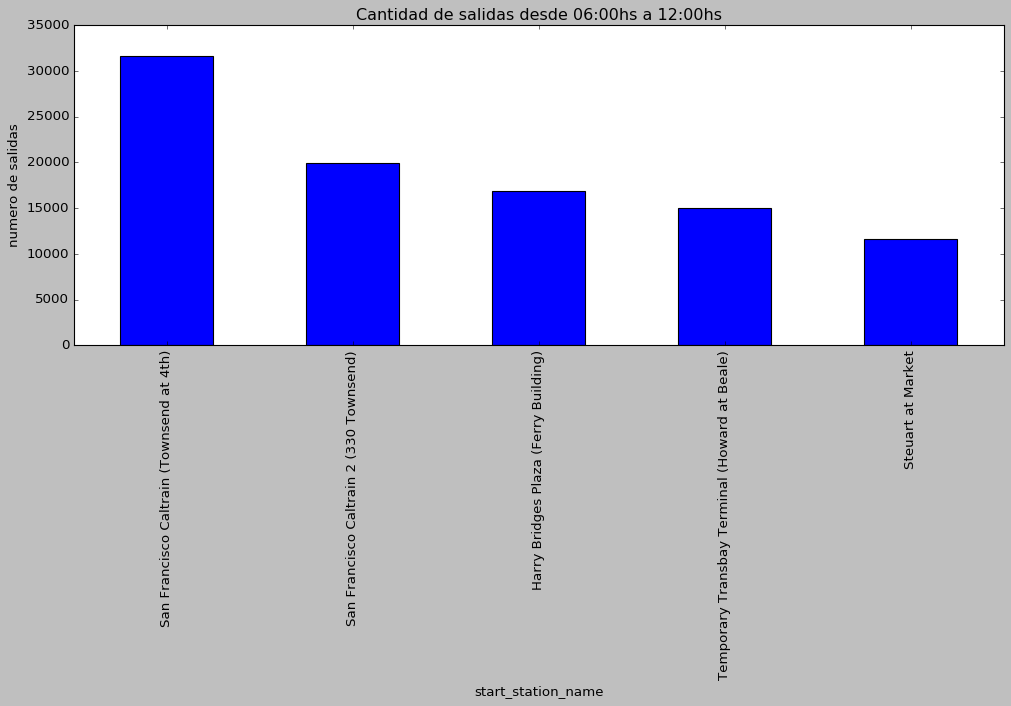

In [54]:
#Agrupo por Estacion y cuento la cantidad de ID de viaje en el grupo para saber cuantas veces fue usada una estacion salida
salida1 = grupoSalidaManiana.groupby(grupoSalidaManiana['start_station_name']).count().sort_values(by='id',ascending = False).id
plt.title('Cantidad de salidas desde 06:00hs a 12:00hs')
plt.ylabel('numero de salidas')
plt.xlabel('estacion de salida')
salida1.head(5).plot(kind = 'bar')
plt.show()

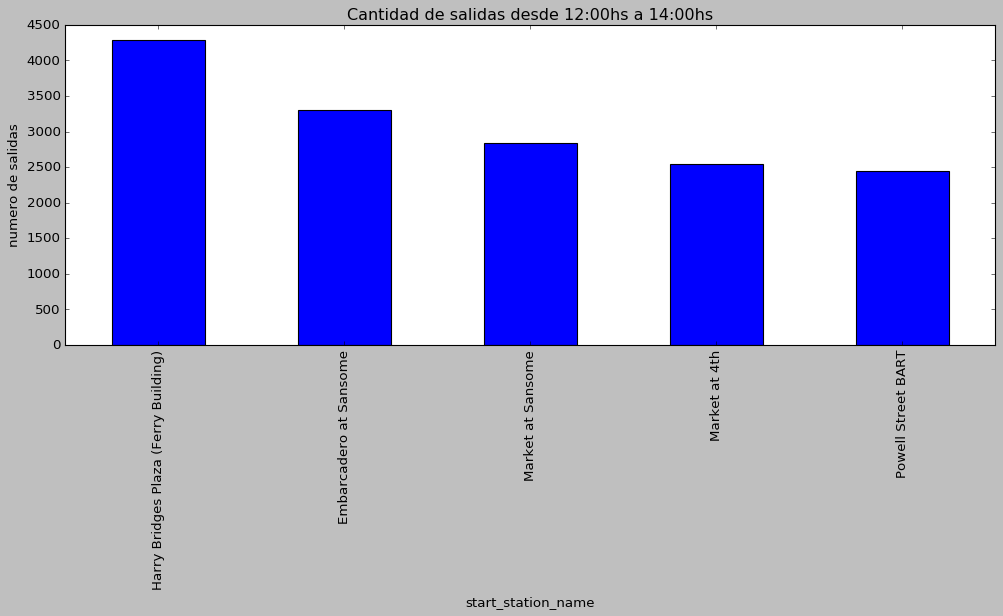

In [55]:
#Estaciones de salida.Franja Horaria Desde las 12 hasta las 14
grupoSalidaMediodia = dfViajes[(dfViajes.start_date.dt.hour >= 12 )&(dfViajes.start_date.dt.hour < 14)]
salida2 = grupoSalidaMediodia.groupby(grupoSalidaMediodia['start_station_name']).count().sort_values(by='id',ascending = False).id
plt.title('Cantidad de salidas desde 12:00hs a 14:00hs')
plt.ylabel('numero de salidas')
plt.xlabel('estacion de salida')
salida2.head(5).plot(kind = 'bar')
plt.show()

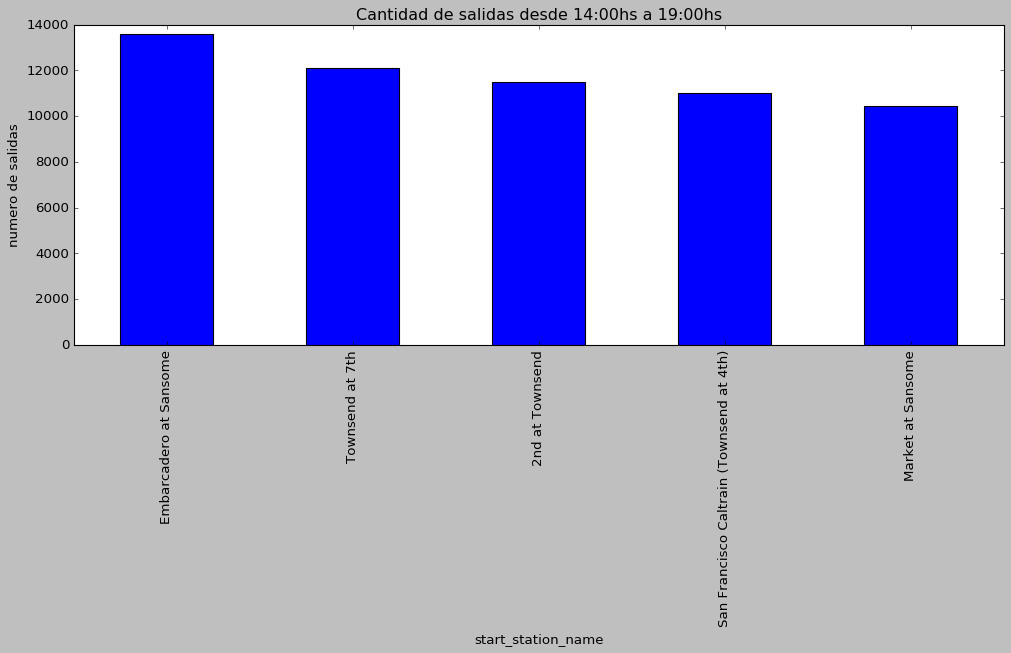

In [56]:
#Estaciones de salida.Franja Horaria Desde las 14  hasta las 19
grupoSalidaTarde = dfViajes[(dfViajes.start_date.dt.hour >= 14 )&(dfViajes.start_date.dt.hour < 19)]
salida3 = grupoSalidaTarde.groupby(grupoSalidaTarde['start_station_name']).count().sort_values(by='id',ascending = False).id
plt.title('Cantidad de salidas desde 14:00hs a 19:00hs')
plt.ylabel('numero de salidas')
plt.xlabel('estacion de salida')
salida3.head(5).plot(kind = 'bar')
plt.show()

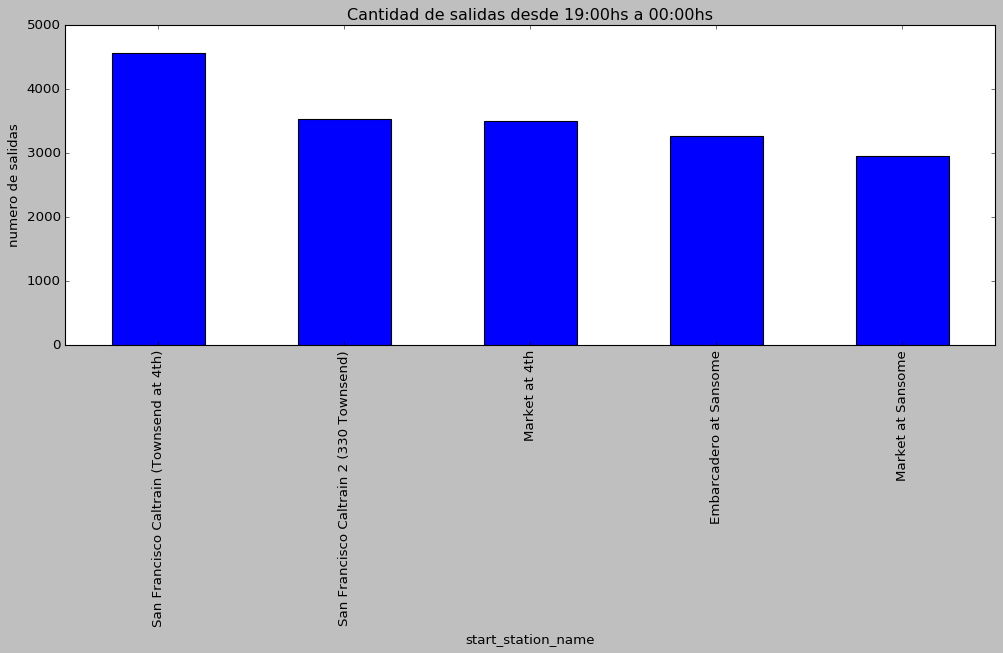

In [57]:
#Estaciones de salida.Franja Horaria Desde las 19  hasta las 00
grupoSalidaNoche = dfViajes[(dfViajes.start_date.dt.hour >= 19)]
salida4 = grupoSalidaNoche.groupby(grupoSalidaNoche['start_station_name']).count().sort_values(by='id',ascending = False).id
plt.title('Cantidad de salidas desde 19:00hs a 00:00hs')
plt.ylabel('numero de salidas')
plt.xlabel('estacion de salida')
salida4.head(5).plot(kind = 'bar')
plt.show()

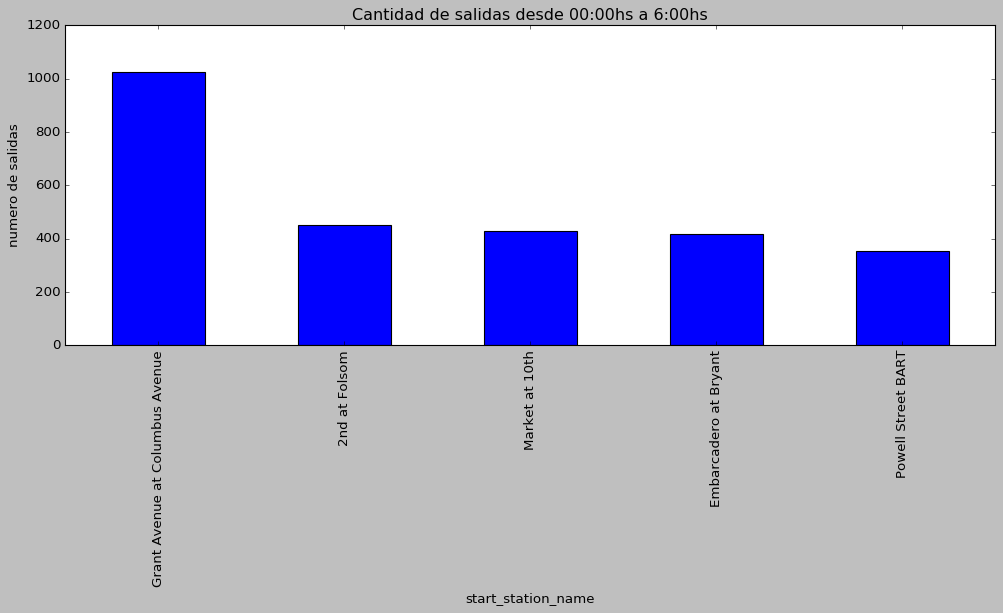

In [58]:
#Estaciones de salida.Franja Horaria Desde las 00 hasta las 6
grupoSalidaTrasnoche = dfViajes[(dfViajes.start_date.dt.hour < 6)]
salida5 = grupoSalidaTrasnoche.groupby(grupoSalidaTrasnoche['start_station_name']).count().sort_values(by='id',ascending = False).id
plt.title('Cantidad de salidas desde 00:00hs a 6:00hs')
plt.ylabel('numero de salidas')
plt.xlabel('estacion de salida')
salida5.head(5).plot(kind = 'bar')
plt.show()

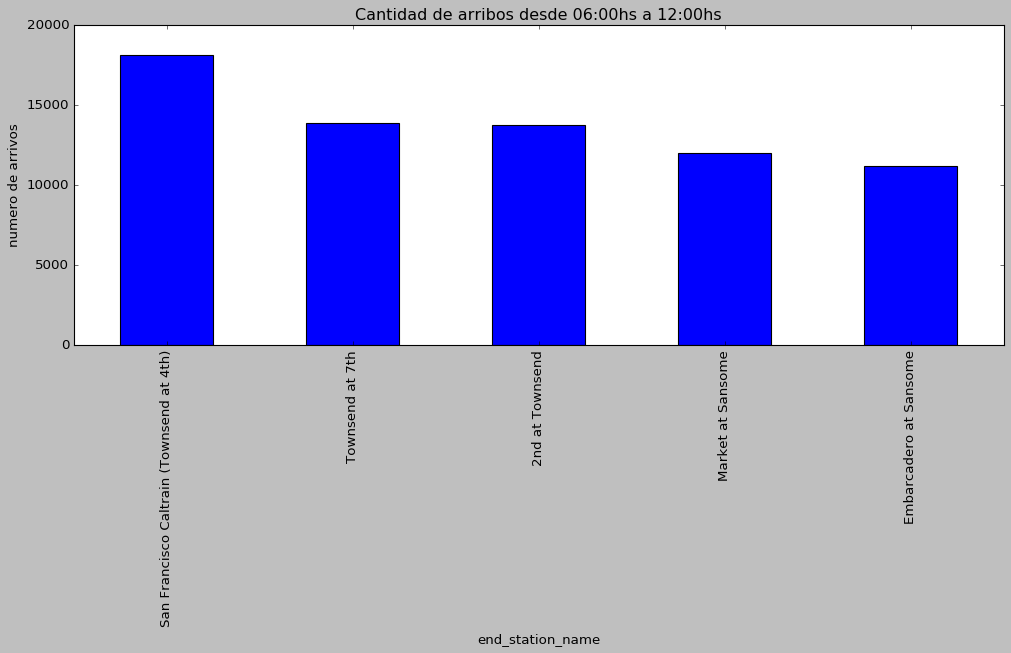

In [59]:
#Estaciones de llegada.Franja Horaria Desde las 06 hasta las 12
grupoLlegadaManiana = dfViajes[(dfViajes.end_date.dt.hour >= 6 )&(dfViajes.end_date.dt.hour < 12)]
llegada1 = grupoLlegadaManiana.groupby(grupoLlegadaManiana['end_station_name']).count().sort_values(by='id',ascending = False).id
plt.title('Cantidad de arribos desde 06:00hs a 12:00hs')
plt.ylabel('numero de arrivos')
plt.xlabel('estacion de llegada')
llegada1.head(5).plot(kind = 'bar')
plt.show()

In [60]:
#Estaciones de llegada.Franja Horaria Desde las 12 hasta las 14
grupoLlegadaMediodia = dfViajes[(dfViajes.end_date.dt.hour >= 12 )&(dfViajes.end_date.dt.hour < 14)]
llegada2 = grupoLlegadaMediodia.groupby(grupoLlegadaMediodia['end_station_name']).count().sort_values(by='id',ascending = False).id
plt.title('Cantidad de arribos desde 12:00hs a 14:00hs')
plt.ylabel('numero de arrivos')
plt.xlabel('estacion de llegada')
llegada2.head(5).plot(kind = 'bar')
plt.show()

In [61]:
#Estaciones de llegada.Franja Horaria Desde las 14 hasta las 19
grupoLlegadaTarde = dfViajes[(dfViajes.end_date.dt.hour >= 14 )&(dfViajes.end_date.dt.hour < 19)]
llegada3 = grupoLlegadaTarde.groupby(grupoLlegadaTarde['end_station_name']).count().sort_values(by='id',ascending = False).id
plt.title('Cantidad de arribos desde 14:00hs a 19:00hs')
plt.ylabel('numero de arribos')
plt.xlabel('estacion de llegada')
llegada3.head(5).plot(kind = 'bar')
plt.show()

In [62]:
#Estaciones de salida.Franja Horaria Desde las 19 hasta las 00
grupoLlegadaNoche = dfViajes[(dfViajes.end_date.dt.hour >= 19)]
llegada4 = grupoLlegadaNoche.groupby(grupoLlegadaNoche['end_station_name']).count().sort_values(by='id',ascending = False).id
plt.title('Cantidad de arribos desde 19:00hs a 00:00hs')
plt.ylabel('numero de arribos')
plt.xlabel('estacion de llegada')
llegada4.head(5).plot(kind = 'bar')
plt.show()

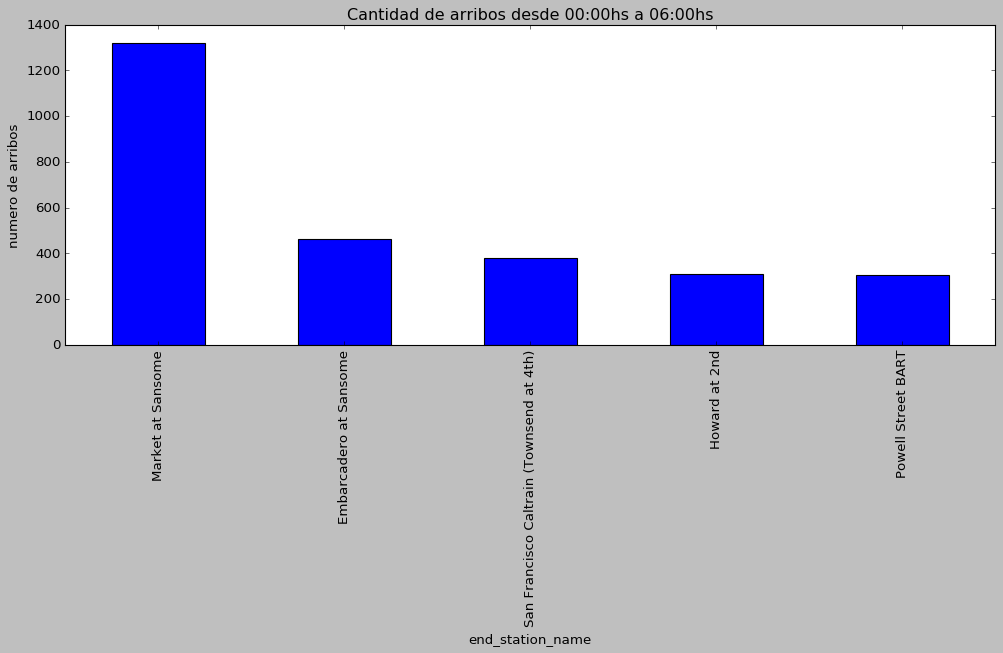

In [63]:
#Estaciones de llegada.Franja Horaria Desde las 00 hasta las 6
grupoLlegadaTrasnoche = dfViajes[(dfViajes.end_date.dt.hour < 6)]
llegada5 = grupoLlegadaTrasnoche.groupby(grupoLlegadaTrasnoche['end_station_name']).count().sort_values(by='id',ascending = False).id
plt.title('Cantidad de arribos desde 00:00hs a 06:00hs')
plt.ylabel('numero de arribos')
plt.xlabel('estacion de llegada')
llegada5.head(5).plot(kind = 'bar')
plt.show()

In [64]:
dfViajes['hour'] = dfViajes.start_date.dt.hour
#averiguamos cuantos viajes se hicieron por hora
viajesHora = {}
for d in dfViajes.hour:
    if d not in viajesHora:
        viajesHora[d] = 1
    else:
        viajesHora[d] += 1
viajesHora

{0: 2171,
 1: 1189,
 2: 692,
 3: 342,
 4: 1022,
 5: 3449,
 6: 14312,
 7: 43939,
 8: 85864,
 9: 62897,
 10: 30106,
 11: 29141,
 12: 34384,
 13: 31740,
 14: 27156,
 15: 33223,
 16: 59099,
 17: 82705,
 18: 57652,
 19: 29188,
 20: 16527,
 21: 11277,
 22: 7434,
 23: 4450}

In [65]:
#Grafico de la cantidad de viajes totales en funcion de las horas.
viajesPorHora = pd.DataFrame.from_dict(viajesHora, orient = 'index')
plt.title('Cantidad de Viajes por franja horaria')
plt.xlabel('horas del dia')
plt.xlim(0,23)
plt.ylabel('viajes totales')
indice = np.arange(24)
valores = ['0:00','1:00','2:00','3:00','4:00','5:00','6:00','7:00','8:00','9:00','10:00','11:00','12:00',
           '13:00','14:00','15:00','16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00']
plt.xticks(indice,valores)
plt.plot(viajesPorHora)
plt.show()

In [66]:
#PARA CADA MES CALCULAR LA DURACION PROMEDIO
import calendar
plt.ion()
meses = calendar.month_name[1:13]
indice = np.arange(12)
duracionPromedioMeses = np.arange(12,dtype=np.float)
dfViajes['month']= dfViajes.start_date.dt.month
for i in duracionPromedioMeses:
    dfViajesMes = dfViajes[dfViajes['month'] == (i + 1)]
    promedioMes = dfViajesMes.duration.mean()
    duracionPromedioMeses[i] = promedioMes
plt.title('Average length of travel according to months of the year')
plt.xlabel('Months')
plt.ylabel('Average duration (minutes)')
plt.xticks(indice,meses, size = 'small', color = 'b', rotation = 45)
plt.plot(duracionPromedioMeses)

plt.show()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



In [93]:
import plotly 
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *

trace0 = go.Bar(
    x=llegada1.head(5),
    name='Cantidad de arribos desde 06:00hs a 12:00hs',
    )

trace1 = go.Bar(
    x=llegada2.head(5),
    name='Cantidad de arribos desde 12:00hs a 14:00hs'
     
)
trace2 = go.Bar(
    x=llegada3.head(5),
    name='Cantidad de arribos desde 14:00hs a 19:00hs'
     
)
trace3 = go.Bar(
    x=llegada4.head(5),
    name='Cantidad de arribos desde 19:00hs a 00:00hs'
     
)
trace4 = go.Bar(
    x=llegada5.head(5),
    name='Cantidad de arribos desde 00:00hs a 06:00hs'
     
)

data = [trace0, trace1,trace2,trace3,trace4]
layout = go.Layout(
    xaxis=dict(tickangle=0),
    barmode='group',
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='angled-text-bar')

In [94]:
import plotly 
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *

trace0 = go.Bar(
    x=salida1.head(5),
    name='Cantidad de salidas desde 06:00hs a 12:00hs',
    )

trace1 = go.Bar(
    x=salida2.head(5),
    name='Cantidad de salidas desde 12:00hs a 14:00hs'
     
)
trace2 = go.Bar(
    x=salida3.head(5),
    name='Cantidad de salidas desde 14:00hs a 19:00hs'
     
)
trace3 = go.Bar(
    x=salida4.head(5),
    name='Cantidad de salidas desde 19:00hs a 00:00hs'
     
)
trace4 = go.Bar(
    x=salida5.head(5),
    name='Cantidad de salidas desde 00:00hs a 06:00hs'
     
)

data = [trace0, trace1,trace2,trace3,trace4]
layout = go.Layout(
    xaxis=dict(tickangle=0),
    barmode='group',
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='angled-text-bar')


#  El objetivo de este nuevo analisis consiste en estudiar la variacion de los viajes con respecto a los dias de semana y a lo largo de un año, asi como tambien comprender como influyen las condiciones meteorologicas con respecto a los viajes en bicicleta. 

In [95]:
dfViajes['date'] = dfViajes.start_date.dt.date
# Averiguamos cuantos viajes se hicieron por dia
dates = {}
for d in dfViajes.date:
    if d not in dates:
        dates[d] = 1
    else:
        dates[d] += 1

In [96]:

dfCantViajes = pd.DataFrame.from_dict(dates, orient = "index")
dfCantViajes['date'] = dfCantViajes.index
dfCantViajes['viajes'] = dfCantViajes.ix[:,0]
dfSF_Bay = dfCantViajes.ix[:,1:3]
dfSF_Bay = dfSF_Bay.sort_values('date') #Ordeno por fecha
dfSF_Bay.reset_index(drop = True, inplace = True) # Queda mas prolijo con indice de 0 a ...
dfSF_Bay

date  viajes
0    2013-08-29     748
1    2013-08-30     714
2    2013-08-31     640
3    2013-09-01     706
4    2013-09-02     661
5    2013-09-03     597
6    2013-09-04     606
7    2013-09-05     677
8    2013-09-06     814
9    2013-09-07     796
10   2013-09-08     704
11   2013-09-09     769
12   2013-09-10     892
13   2013-09-11     880
14   2013-09-12     942
15   2013-09-13     981
16   2013-09-14     702
17   2013-09-15     624
18   2013-09-16     914
19   2013-09-17    1073
20   2013-09-18    1110
21   2013-09-19    1044
22   2013-09-20    1102
23   2013-09-21     388
24   2013-09-22     584
25   2013-09-23    1050
26   2013-09-24    1075
27   2013-09-25    1264
28   2013-09-26    1082
29   2013-09-27    1101
..          ...     ...
703  2015-08-02     320
704  2015-08-03    1283
705  2015-08-04    1360
706  2015-08-05    1341
707  2015-08-06    1299
708  2015-08-07    1197
709  2015-08-08     432
710  2015-08-09     361
711  2015-08-10    1284
712  2015-08-11    1397
713  2015-08-12    1400
714  2015-08-13    1401
715  2015-08-14    1182
716  2015-08-15     451
717  2015-08-16     393
718  2015-08-17    1418
719  2015-08-18    1407
720  2015-08-19    1353
721  2015-08-20    1353
722  2015-08-21    1215
723  2015-08-22     421
724  2015-08-23     311
725  2015-08-24    1309
726  2015-08-25    1421
727  2015-08-26    1465
728  2015-08-27    1443
729  2015-08-28    1220
730  2015-08-29     342
731  2015-08-30     331
732  2015-08-31    1369

[733 rows x 2 columns]

In [97]:
data = [go.Scatter( x=dfSF_Bay['date'], y=dfSF_Bay['viajes'] )]

layout = dict(
    title='Distribucion de viajes en linea de tiempo',
    yaxis=dict(title='Viajes')
           
    )
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Time Series with Rangeslider")

In [98]:
data = [go.Scatter(
          x=dfSF_Bay.date,
          y=dfSF_Bay.viajes,
            mode='markers',
    showlegend=False)
           ]
layout = dict(
    title='Distribucion de viajes en linea de tiempo',
    yaxis=dict(title='Viajes')
           
    )
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Time Series with Rangeslider")

In [99]:
print((dfCantViajes).info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 733 entries, 2015-07-26 to 2014-01-29
Data columns (total 3 columns):
0         733 non-null int64
date      733 non-null object
viajes    733 non-null int64
dtypes: int64(2), object(1)
memory usage: 22.9+ KB
None


In [100]:
print((dfViajes).info()) 


<class 'pandas.core.frame.DataFrame'>
Int64Index: 669959 entries, 0 to 669958
Data columns (total 14 columns):
id                    669959 non-null int64
duration              669959 non-null float64
start_date            669959 non-null datetime64[ns]
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null datetime64[ns]
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
hour                  669959 non-null int64
month                 669959 non-null int64
date                  669959 non-null object
dtypes: datetime64[ns](2), float64(1), int64(6), object(5)
memory usage: 76.7+ MB
None


In [101]:
#Hacemos un merge, para obtener los viajes con el clima
dfSF_Bay = dfSF_Bay.merge(dfClimaLimpio, on = dfSF_Bay.date)
dfSF_Bay

date_x  viajes     date_y  max_temperature_c  mean_temperature_c  \
0    2013-08-29     748 2013-08-29          23.333333           20.000000   
1    2013-08-30     714 2013-08-30          25.555556           20.555556   
2    2013-08-31     640 2013-08-31          21.666667           17.777778   
3    2013-09-01     706 2013-09-01          23.333333           18.888889   
4    2013-09-02     661 2013-09-02          23.888889           20.555556   
5    2013-09-03     597 2013-09-03          22.777778           19.444444   
6    2013-09-04     606 2013-09-04          23.333333           20.000000   
7    2013-09-05     677 2013-09-05          22.222222           18.888889   
8    2013-09-06     814 2013-09-06          29.444444           21.666667   
9    2013-09-07     796 2013-09-07          31.111111           22.777778   
10   2013-09-08     704 2013-09-08          23.333333           18.333333   
11   2013-09-09     769 2013-09-09          24.444444           18.888889   
12   2013-09-10     892 2013-09-10          23.333333           18.888889   
13   2013-09-11     880 2013-09-11          23.333333           20.000000   
14   2013-09-12     942 2013-09-12          21.666667           18.333333   
15   2013-09-13     981 2013-09-13          18.888889           16.666667   
16   2013-09-14     702 2013-09-14          18.888889           16.666667   
17   2013-09-15     624 2013-09-15          22.777778           18.888889   
18   2013-09-16     914 2013-09-16          21.666667           18.333333   
19   2013-09-17    1073 2013-09-17          20.000000           17.222222   
20   2013-09-18    1110 2013-09-18          25.555556           18.888889   
21   2013-09-19    1044 2013-09-19          26.666667           19.444444   
22   2013-09-20    1102 2013-09-20          22.777778           18.333333   
23   2013-09-21     388 2013-09-21          20.000000           17.222222   
24   2013-09-22     584 2013-09-22          21.111111           17.222222   
25   2013-09-23    1050 2013-09-23          25.555556           20.000000   
26   2013-09-24    1075 2013-09-24          21.666667           18.333333   
27   2013-09-25    1264 2013-09-25          19.444444           16.666667   
28   2013-09-26    1082 2013-09-26          21.666667           16.666667   
29   2013-09-27    1101 2013-09-27          25.555556           18.888889   
..          ...     ...        ...                ...                 ...   
703  2015-08-02     320 2015-08-02          22.777778           20.000000   
704  2015-08-03    1283 2015-08-03          23.888889           21.111111   
705  2015-08-04    1360 2015-08-04          23.888889           20.555556   
706  2015-08-05    1341 2015-08-05          25.000000           19.444444   
707  2015-08-06    1299 2015-08-06          22.222222           18.333333   
708  2015-08-07    1197 2015-08-07          25.000000           20.555556   
709  2015-08-08     432 2015-08-08          21.111111           18.888889   
710  2015-08-09     361 2015-08-09          22.222222           18.888889   
711  2015-08-10    1284 2015-08-10          22.777778           19.444444   
712  2015-08-11    1397 2015-08-11          22.777778           19.444444   
713  2015-08-12    1400 2015-08-12          25.555556           19.444444   
714  2015-08-13    1401 2015-08-13          24.444444           21.111111   
715  2015-08-14    1182 2015-08-14          24.444444           20.555556   
716  2015-08-15     451 2015-08-15          33.333333           23.888889   
717  2015-08-16     393 2015-08-16          33.888889           25.000000   
718  2015-08-17    1418 2015-08-17          26.666667           21.111111   
719  2015-08-18    1407 2015-08-18          23.888889           20.000000   
720  2015-08-19    1353 2015-08-19          23.333333           20.555556   
721  2015-08-20    1353 2015-08-20          21.111111           18.888889   
722  2015-08-21    1215 2015-08-21          20.555556           18.888889   
723  

In [102]:
dfSF_Bay['date'] = dfSF_Bay['date_x']
dfSF_Bay.drop(['date_y','date_x'],1, inplace= True)
#Limpio esos features repetidos

In [103]:
dfSF_Bay #todo ok

viajes  max_temperature_c  mean_temperature_c  min_temperature_c  \
0       748          23.333333           20.000000          16.111111   
1       714          25.555556           20.555556          15.555556   
2       640          21.666667           17.777778          13.888889   
3       706          23.333333           18.888889          14.444444   
4       661          23.888889           20.555556          16.666667   
5       597          22.777778           19.444444          15.555556   
6       606          23.333333           20.000000          16.111111   
7       677          22.222222           18.888889          15.555556   
8       814          29.444444           21.666667          13.333333   
9       796          31.111111           22.777778          14.444444   
10      704          23.333333           18.333333          13.333333   
11      769          24.444444           18.888889          12.777778   
12      892          23.333333           18.888889          13.888889   
13      880          23.333333           20.000000          16.666667   
14      942          21.666667           18.333333          15.000000   
15      981          18.888889           16.666667          13.888889   
16      702          18.888889           16.666667          13.888889   
17      624          22.777778           18.888889          14.444444   
18      914          21.666667           18.333333          15.000000   
19     1073          20.000000           17.222222          13.888889   
20     1110          25.555556           18.888889          12.222222   
21     1044          26.666667           19.444444          12.222222   
22     1102          22.777778           18.333333          13.333333   
23      388          20.000000           17.222222          14.444444   
24      584          21.111111           17.222222          12.777778   
25     1050          25.555556           20.000000          13.888889   
26     1075          21.666667           18.333333          14.444444   
27     1264          19.444444           16.666667          13.333333   
28     1082          21.666667           16.666667          11.666667   
29     1101          25.555556           18.888889          12.222222   
..      ...                ...                 ...                ...   
703     320          22.777778           20.000000          17.222222   
704    1283          23.888889           21.111111          17.777778   
705    1360          23.888889           20.555556          16.666667   
706    1341          25.000000           19.444444          13.888889   
707    1299          22.222222           18.333333          14.444444   
708    1197          25.000000           20.555556          16.111111   
709     432          21.111111           18.888889          16.666667   
710     361          22.222222           18.888889          15.000000   
711    1284          22.777778           19.444444          15.555556   
712    1397          22.777778           19.444444          16.111111   
713    1400          25.555556           19.444444          12.777778   
714    1401          24.444444           21.111111          17.777778   
715    1182          24.444444           20.555556          16.111111   
716     451          33.333333           23.888889          13.888889   
717     393          33.888889           25.000000          16.111111   
718    1418          26.666667           21.111111          15.000000   
719    1407          23.888889           20.000000          16.111111   
720    1353          23.333333           20.555556          17.222222   
721    1353          21.111111           18.888889          16.666667   
722    1215          20.555556           18.888889          16.666667   
723     421          23.888889           20.000000          16.111111   
724     311          22.777778           19.444444          16.111111   
725    1309          23.888889           20.000000          16.

In [104]:
#Buscamos los feriados en el calendario estadounidense
calendar = USFederalHolidayCalendar()
holidays = calendar.holidays(start=dfSF_Bay.date.min(), end=dfSF_Bay.date.max())
holidays

DatetimeIndex(['2013-09-02', '2013-10-14', '2013-11-11', '2013-11-28',
               '2013-12-25', '2014-01-01', '2014-01-20', '2014-02-17',
               '2014-05-26', '2014-07-04', '2014-09-01', '2014-10-13',
               '2014-11-11', '2014-11-27', '2014-12-25', '2015-01-01',
               '2015-01-19', '2015-02-16', '2015-05-25', '2015-07-03'],
              dtype='datetime64[ns]', freq=None)

In [105]:
#Buscamos los dias laborables en el calendario estadounidense
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
business_days = pd.DatetimeIndex(start=dfSF_Bay.date.min(), end=dfSF_Bay.date.max(), freq=us_bd)

In [106]:
business_days = pd.to_datetime(business_days, format='%Y/%m/%d').date
holidays = pd.to_datetime(holidays, format='%Y/%m/%d').date

In [107]:
# Lo agregamos al dataframe
dfSF_Bay['business_day'] = dfSF_Bay.date.isin(business_days)
dfSF_Bay['holiday'] = dfSF_Bay.date.isin(holidays)
dfSF_Bay

viajes  max_temperature_c  mean_temperature_c  min_temperature_c  \
0       748          23.333333           20.000000          16.111111   
1       714          25.555556           20.555556          15.555556   
2       640          21.666667           17.777778          13.888889   
3       706          23.333333           18.888889          14.444444   
4       661          23.888889           20.555556          16.666667   
5       597          22.777778           19.444444          15.555556   
6       606          23.333333           20.000000          16.111111   
7       677          22.222222           18.888889          15.555556   
8       814          29.444444           21.666667          13.333333   
9       796          31.111111           22.777778          14.444444   
10      704          23.333333           18.333333          13.333333   
11      769          24.444444           18.888889          12.777778   
12      892          23.333333           18.888889          13.888889   
13      880          23.333333           20.000000          16.666667   
14      942          21.666667           18.333333          15.000000   
15      981          18.888889           16.666667          13.888889   
16      702          18.888889           16.666667          13.888889   
17      624          22.777778           18.888889          14.444444   
18      914          21.666667           18.333333          15.000000   
19     1073          20.000000           17.222222          13.888889   
20     1110          25.555556           18.888889          12.222222   
21     1044          26.666667           19.444444          12.222222   
22     1102          22.777778           18.333333          13.333333   
23      388          20.000000           17.222222          14.444444   
24      584          21.111111           17.222222          12.777778   
25     1050          25.555556           20.000000          13.888889   
26     1075          21.666667           18.333333          14.444444   
27     1264          19.444444           16.666667          13.333333   
28     1082          21.666667           16.666667          11.666667   
29     1101          25.555556           18.888889          12.222222   
..      ...                ...                 ...                ...   
703     320          22.777778           20.000000          17.222222   
704    1283          23.888889           21.111111          17.777778   
705    1360          23.888889           20.555556          16.666667   
706    1341          25.000000           19.444444          13.888889   
707    1299          22.222222           18.333333          14.444444   
708    1197          25.000000           20.555556          16.111111   
709     432          21.111111           18.888889          16.666667   
710     361          22.222222           18.888889          15.000000   
711    1284          22.777778           19.444444          15.555556   
712    1397          22.777778           19.444444          16.111111   
713    1400          25.555556           19.444444          12.777778   
714    1401          24.444444           21.111111          17.777778   
715    1182          24.444444           20.555556          16.111111   
716     451          33.333333           23.888889          13.888889   
717     393          33.888889           25.000000          16.111111   
718    1418          26.666667           21.111111          15.000000   
719    1407          23.888889           20.000000          16.111111   
720    1353          23.333333           20.555556          17.222222   
721    1353          21.111111           18.888889          16.666667   
722    1215          20.555556           18.888889          16.666667   
723     421          23.888889           20.000000          16.111111   
724     311          22.777778           19.444444          16.111111   
725    1309          23.888889           20.000000          16.

In [108]:
dfSF_Bay.dtypes

viajes                          int64
max_temperature_c             float64
mean_temperature_c            float64
min_temperature_c             float64
max_dew_point_c               float64
mean_dew_point_c              float64
min_dew_point_c               float64
max_humidity                  float64
mean_humidity                 float64
min_humidity                  float64
max_sea_level_pressure_cm     float64
mean_sea_level_pressure_cm    float64
min_sea_level_pressure_cm     float64
max_visibility_km             float64
mean_visibility_km            float64
min_visibility_km             float64
max_wind_Speed_kmh            float64
mean_wind_speed_kmh           float64
max_gust_speed_kmh            float64
precipitation_cm              float64
cloud_cover                   float64
wind_dir_degrees              float64
Fog                           float64
Fog-Rain                      float64
Normal                        float64
Rain                          float64
Rain-Thunder

In [109]:
#Convert True to 1 and False to 0
dfSF_Bay.business_day = dfSF_Bay.business_day.map(lambda x: 1 if x == True else 0)
dfSF_Bay.holiday = dfSF_Bay.holiday.map(lambda x: 1 if x == True else 0)
dfSF_Bay

viajes  max_temperature_c  mean_temperature_c  min_temperature_c  \
0       748          23.333333           20.000000          16.111111   
1       714          25.555556           20.555556          15.555556   
2       640          21.666667           17.777778          13.888889   
3       706          23.333333           18.888889          14.444444   
4       661          23.888889           20.555556          16.666667   
5       597          22.777778           19.444444          15.555556   
6       606          23.333333           20.000000          16.111111   
7       677          22.222222           18.888889          15.555556   
8       814          29.444444           21.666667          13.333333   
9       796          31.111111           22.777778          14.444444   
10      704          23.333333           18.333333          13.333333   
11      769          24.444444           18.888889          12.777778   
12      892          23.333333           18.888889          13.888889   
13      880          23.333333           20.000000          16.666667   
14      942          21.666667           18.333333          15.000000   
15      981          18.888889           16.666667          13.888889   
16      702          18.888889           16.666667          13.888889   
17      624          22.777778           18.888889          14.444444   
18      914          21.666667           18.333333          15.000000   
19     1073          20.000000           17.222222          13.888889   
20     1110          25.555556           18.888889          12.222222   
21     1044          26.666667           19.444444          12.222222   
22     1102          22.777778           18.333333          13.333333   
23      388          20.000000           17.222222          14.444444   
24      584          21.111111           17.222222          12.777778   
25     1050          25.555556           20.000000          13.888889   
26     1075          21.666667           18.333333          14.444444   
27     1264          19.444444           16.666667          13.333333   
28     1082          21.666667           16.666667          11.666667   
29     1101          25.555556           18.888889          12.222222   
..      ...                ...                 ...                ...   
703     320          22.777778           20.000000          17.222222   
704    1283          23.888889           21.111111          17.777778   
705    1360          23.888889           20.555556          16.666667   
706    1341          25.000000           19.444444          13.888889   
707    1299          22.222222           18.333333          14.444444   
708    1197          25.000000           20.555556          16.111111   
709     432          21.111111           18.888889          16.666667   
710     361          22.222222           18.888889          15.000000   
711    1284          22.777778           19.444444          15.555556   
712    1397          22.777778           19.444444          16.111111   
713    1400          25.555556           19.444444          12.777778   
714    1401          24.444444           21.111111          17.777778   
715    1182          24.444444           20.555556          16.111111   
716     451          33.333333           23.888889          13.888889   
717     393          33.888889           25.000000          16.111111   
718    1418          26.666667           21.111111          15.000000   
719    1407          23.888889           20.000000          16.111111   
720    1353          23.333333           20.555556          17.222222   
721    1353          21.111111           18.888889          16.666667   
722    1215          20.555556           18.888889          16.666667   
723     421          23.888889           20.000000          16.111111   
724     311          22.777778           19.444444          16.111111   
725    1309          23.888889           20.000000          16.

In [110]:
#Convert date to the important features, year, month, weekday (0 = Monday, 1 = Tuesday...)
#We don't need day because what it represents changes every year.
dfSF_Bay['year'] = pd.to_datetime(dfSF_Bay['date']).dt.year
dfSF_Bay['month'] = pd.to_datetime(dfSF_Bay['date']).dt.month
dfSF_Bay['weekday'] = pd.to_datetime(dfSF_Bay['date']).dt.weekday
dfSF_Bay

viajes  max_temperature_c  mean_temperature_c  min_temperature_c  \
0       748          23.333333           20.000000          16.111111   
1       714          25.555556           20.555556          15.555556   
2       640          21.666667           17.777778          13.888889   
3       706          23.333333           18.888889          14.444444   
4       661          23.888889           20.555556          16.666667   
5       597          22.777778           19.444444          15.555556   
6       606          23.333333           20.000000          16.111111   
7       677          22.222222           18.888889          15.555556   
8       814          29.444444           21.666667          13.333333   
9       796          31.111111           22.777778          14.444444   
10      704          23.333333           18.333333          13.333333   
11      769          24.444444           18.888889          12.777778   
12      892          23.333333           18.888889          13.888889   
13      880          23.333333           20.000000          16.666667   
14      942          21.666667           18.333333          15.000000   
15      981          18.888889           16.666667          13.888889   
16      702          18.888889           16.666667          13.888889   
17      624          22.777778           18.888889          14.444444   
18      914          21.666667           18.333333          15.000000   
19     1073          20.000000           17.222222          13.888889   
20     1110          25.555556           18.888889          12.222222   
21     1044          26.666667           19.444444          12.222222   
22     1102          22.777778           18.333333          13.333333   
23      388          20.000000           17.222222          14.444444   
24      584          21.111111           17.222222          12.777778   
25     1050          25.555556           20.000000          13.888889   
26     1075          21.666667           18.333333          14.444444   
27     1264          19.444444           16.666667          13.333333   
28     1082          21.666667           16.666667          11.666667   
29     1101          25.555556           18.888889          12.222222   
..      ...                ...                 ...                ...   
703     320          22.777778           20.000000          17.222222   
704    1283          23.888889           21.111111          17.777778   
705    1360          23.888889           20.555556          16.666667   
706    1341          25.000000           19.444444          13.888889   
707    1299          22.222222           18.333333          14.444444   
708    1197          25.000000           20.555556          16.111111   
709     432          21.111111           18.888889          16.666667   
710     361          22.222222           18.888889          15.000000   
711    1284          22.777778           19.444444          15.555556   
712    1397          22.777778           19.444444          16.111111   
713    1400          25.555556           19.444444          12.777778   
714    1401          24.444444           21.111111          17.777778   
715    1182          24.444444           20.555556          16.111111   
716     451          33.333333           23.888889          13.888889   
717     393          33.888889           25.000000          16.111111   
718    1418          26.666667           21.111111          15.000000   
719    1407          23.888889           20.000000          16.111111   
720    1353          23.333333           20.555556          17.222222   
721    1353          21.111111           18.888889          16.666667   
722    1215          20.555556           18.888889          16.666667   
723     421          23.888889           20.000000          16.111111   
724     311          22.777778           19.444444          16.111111   
725    1309          23.888889           20.000000          16.

In [111]:
#Lo usamos para grafico Meses vs Viajes
meses = dfSF_Bay.groupby('month').sum()
#Lo usamos para grafico Dias vs Viajes
dia = dfSF_Bay.groupby('weekday').sum()


In [112]:
data = [go.Scatter(
          x=['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'],
          y=meses.viajes)]
layout = dict(
    title='Cantidad de viajes por mes',
    xaxis=dict(title='Meses'),
    yaxis=dict(title='Viajes') 
    )
fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Time Series with Rangeslider")


In [113]:
x1=['Lunes','Martes','Miercoles','Jueves','Viernes','Sabado','Domingo']
data= [go.Scatter(
          x=x1,
          y=dia.viajes)]

layout = dict(
    title='Cantidad de viajes por mes',
    xaxis=dict(title='Dia'),
    yaxis=dict(title='Viajes')
       
      
    )


fig = dict(data=data, layout=layout)
plotly.offline.iplot(fig, filename = "Time Series with Rangeslider")

### DFTIMELINE

In [114]:
from collections import defaultdict
salida = {}
entrada ={}
epa = []
for d in dfViajes.end_station_name:
    if d not in salida:
        salida[d] =1
    else:
        salida[d] +=1
        
for d in dfViajes.start_station_name:
    if d not in entrada:
        entrada[d] =1
    else:
        entrada[d] +=1  
        
        
a=salida.items()
b=entrada.items()
a.extend(b)
d = defaultdict(list)
for k, v in a:
    d[k].append(v)
    

In [115]:
dfRanking = pd.DataFrame.from_dict(d, orient="index")
dfRanking['name'] = dfRanking.index
dfRanking['bicicletas_que_salieron']= dfRanking.ix[:,0].astype(float)
dfRanking['bicicletas_que_entraron']= dfRanking.ix[:,1].astype(float)
dfRanking['promedio']= (dfRanking.bicicletas_que_entraron + dfRanking.bicicletas_que_salieron)/2

dfRanking.reset_index(drop=True, inplace=True)
#dfRanking.drop([0,1],1)

del dfRanking[0]
del dfRanking[1]

In [140]:
dfTimeline = pd.DataFrame(columns=['name','Inauguracion','Uso_de_Estacion_P','Salida_P','Entrada_P'])
dfTimeline.name = dfEstaciones.name
dfTimeline.Inauguracion = dfEstaciones.installation_date
dfTimeline = pd.merge(dfTimeline, dfRanking, on='name', how='inner')
dfTimeline.Inauguracion = pd.to_datetime(dfTimeline.Inauguracion, format = "%Y/%m/%d")

dfTimeline = pd.merge(dfTimeline, dfEstaciones, on='name', how='inner')
del dfTimeline['installation_date']


ValueError: time data datetime.date(2013, 8, 6) does not match format '%Y/%m/%d' (match)

In [117]:
bicicletasQueSalieron = dfTimeline.bicicletas_que_salieron.sum()
bicicletasQueEntraron = dfTimeline.bicicletas_que_entraron.sum()
bicicletasPromedio = dfTimeline.promedio.sum()

dfTimeline.Uso_de_Estacion_P = dfTimeline.promedio.apply(lambda x: (100*x)/bicicletasPromedio)
dfTimeline.Salida_P = dfTimeline.bicicletas_que_salieron.apply(lambda x: float((100*x)/bicicletasQueSalieron))
dfTimeline.Entrada_P = dfTimeline.bicicletas_que_entraron.apply(lambda x: float((100*x)/bicicletasQueEntraron))


In [118]:
dfTimeline.sort_values(by='promedio', ascending=False)


name Inauguracion  \
58       San Francisco Caltrain (Townsend at 4th)   2013-08-23   
57        San Francisco Caltrain 2 (330 Townsend)   2013-08-23   
39           Harry Bridges Plaza (Ferry Building)   2013-08-20   
48                         Embarcadero at Sansome   2013-08-21   
49                                2nd at Townsend   2013-08-22   
65                              Market at Sansome   2013-08-25   
53                                Townsend at 7th   2013-08-22   
62                              Steuart at Market   2013-08-25   
43  Temporary Transbay Terminal (Howard at Beale)   2013-08-20   
64                                  Market at 4th   2013-08-25   
41                             Powell Street BART   2013-08-25   
55                                 Market at 10th   2013-08-23   
52                              2nd at South Park   2013-08-22   
60              Civic Center BART (7th at Market)   2013-08-23   
45                                  5th at Howard   2013-08-21   
42                          Embarcadero at Bryant   2013-08-20   
44                                Beale at Market   2013-08-20   
40                          Embarcadero at Folsom   2013-08-20   
51                                  Howard at 2nd   2013-08-22   
50                                  2nd at Folsom   2013-08-22   
61                Grant Avenue at Columbus Avenue   2013-08-21   
63            Mechanics Plaza (Market at Battery)   2013-08-25   
54                       South Van Ness at Market   2013-08-23   
38                                Spear at Folsom   2013-08-20   
56  Yerba Buena Center of the Arts (3rd @ Howard)   2013-08-23   
34                       Commercial at Montgomery   2013-08-19   
37                         Embarcadero at Vallejo   2013-08-19   
59                  Powell at Post (Union Square)   2013-08-23   
33                               Davis at Jackson   2013-08-19   
32                                Clay at Battery   2013-08-19   
..                                            ...          ...   
9                                     MLK Library   2013-08-06   
7                                       Japantown   2013-08-05   
22                   San Antonio Caltrain Station   2013-08-15   
8                              San Jose City Hall   2013-08-06   
27                     Palo Alto Caltrain Station   2013-08-14   
25               Castro Street and El Camino Real   2013-12-31   
24                    San Antonio Shopping Center   2013-12-31   
6                             San Salvador at 1st   2013-08-05   
1                           San Jose Civic Center   2013-08-05   
28                         University and Emerson   2013-08-15   
35                          Washington at Kearney   2013-08-19   
69                                    Ryland Park   2014-04-09   
11                                  St James Park   2013-08-06   
23                           Evelyn Park and Ride   2013-08-16   
13                     SJSU - San Salvador at 9th   2013-08-07   
12                       Arena Green / SAP Center   2013-08-05   
15                  Redwood City Caltrain Station   2013-08-15   
10                         SJSU 4th at San Carlos   2013-08-07   
30                           Cowper at University   2013-08-14   
3                                Adobe on Almaden   2013-08-05   
26          Rengstorff Avenue / California Street   2013-08-16   
29                California Ave Caltrain Station   2013-08-14   
66                Santa Clara County Civic Center   2013-12-31   
31                                  Park at Olive   2013-08-14   
18                       Stanford in Redwood City   2013-08-12   
19                    Redwood City Medical Center   2013-08-12   
16                        San Mateo County Center   2013-08-15   
68                                     Mezes Park   2014-02-20   
17                    Redwood City Public Library   2013-08-12   
14                 

In [119]:
import plotly 
import plotly.graph_objs as go
import plotly.plotly as py
from plotly.graph_objs import *
plotly.offline.init_notebook_mode()
plotly.tools.set_credentials_file(username='AARdfSF_Bay', api_key='XFLHonutbTpz1cZ77dcl')



In [120]:
dfTimeline = dfTimeline.sort_values(by= 'Uso_de_Estacion_P')
data = [
    go.Bar(
        x=dfTimeline.Uso_de_Estacion_P, # assign x as the dataframe column 'x'
        y=dfTimeline.name,
        orientation='h',
        
    )
]
layout = dict(
    title='Ranking de estaciones por uso',
    xaxis=dict(title='Porcentaje con respecto al total de estaciones'),     
    )

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='stacked-bar')


In [121]:
dfTimeline = dfTimeline.sort_values(by= 'Salida_P', ascending=False)
data =  [go.Bar(
        x=dfTimeline.Salida_P.head(10), # assign x as the dataframe column 'x'
        y=dfTimeline.name,
        orientation='h',
        )]
    

layout = dict(
    title='Top 10 estaciones por promedio de salida',
    xaxis=dict(title='Porcentaje con respecto al total de estaciones'),     
    )

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='stacked-bar')



In [122]:
dfTimeline = dfTimeline.sort_values(by= 'Entrada_P', ascending=False)
data =  [go.Bar(
        x=dfTimeline.Entrada_P.head(10), # assign x as the dataframe column 'x'
        y=dfTimeline.name,
        orientation='h',
        )]
    

layout = dict(
    title='Top 10 estaciones por promedio de entrada',
    xaxis=dict(title='Porcentaje con respecto al total de estaciones'),     
    )

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='stacked-bar')


In [123]:

cantidades = dfTimeline.groupby('city', as_index=False).count()
cantidades = cantidades['name']
trace1 = go.Bar(
    x=['Mountain View', 'Palo Alto', 'Redwood City', 'San Francisco', 'San Jose'],
    y=cantidades.values.tolist(),

)
data = [trace1]
layout = dict(
    title='Cantidad de estaciones por ciudad',
)

fig = go.Figure(data=data, layout=layout)
plotly.offline.iplot(fig, filename='stacked-bar')




KeyError: 'city'

In [124]:
dfSF_BayHeatmap2 =dfSF_Bay.loc[:,ejeY].corr().head(1)
fig, ax = plt.subplots(figsize=(11,6)); 
df =dfSF_BayHeatmap2.drop(['viajes'],1)
ax = plt.axes()
cg=sns.heatmap(df,cmap='RdBu_r', ax = ax)
ax.set_title('Correlacion cantidad de viajes con parametros')
for item in cg.get_xticklabels():
    item.set_rotation(90)
plt.gcf().subplots_adjust(bottom=0.6)


NameError: name 'ejeY' is not defined

In [125]:
dfTimeline = dfTimeline.sort_values('Inauguracion')
data = [
    go.Scatter(
        x=dfTimeline.id.count(), 
        y=dfTimeline.Inauguracion
    )
]
layout = dict(
    title='Creacion de estaciones a lo largo del tiempo',
    xaxis=dict(title='Cantidad de estaciones'),     
    )
fig = go.Figure(data=data, layout=layout)
url = plotly.offline.iplot(fig, filename='pandas-horizontal-bar')



AttributeError: 'DataFrame' object has no attribute 'id'

# Finalmente se propone un analisis desde la perspectiva geolocalizada, estudiar las variables analizadas anteriormente en la distribucion de un mapa de diversas formas.

In [126]:
latPromedio = dfEstaciones.lat.mean()
longPromedio = dfEstaciones.long.mean()
cantidadTotalDeBicicletasSoportadas = dfEstaciones.dock_count.sum()
print cantidadTotalDeBicicletasSoportadas

1236


In [127]:
map1 = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
map1Copy = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
map2 = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
startStationMap = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
viajesEntreEstacionesMap = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")

In [128]:
grupoDeUbicaciones = folium.FeatureGroup(name='Ubicación de estaciones 1')
for lat, lon, nombre in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name):
    grupoDeUbicaciones.add_child(folium.Marker(location=[lat,lon], popup=nombre))
    
map1.add_child(grupoDeUbicaciones)

In [129]:
# Ahora intento version con MarkerCluster
# map1Copy.add_child(folium.MarkerCluster(locations=list(zip(dfEstaciones.long, dfEstaciones.lat))))

clusterDeUbicaciones = folium.MarkerCluster().add_to(map1Copy)
for lat, lon, nombre in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicaciones)
    
# map1.add_child(grupoDeUbicaciones)
map1Copy

In [130]:
grupoDeUbicacionesConCantidades = folium.FeatureGroup(name='Ubicación de estaciones')
for lat, lon, nombre, cantidadDeBicicletasSoportadas in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name, dfEstaciones.dock_count):
    grupoDeUbicacionesConCantidades.add_child(folium.CircleMarker(location=[lat,lon], popup=nombre, 
                                                     radius=cantidadDeBicicletasSoportadas, 
                                                     fill_color='#b3ffb3', color='#00ff00'))
    
map2.add_child(grupoDeUbicacionesConCantidades)

In [131]:
dfStartStationCount = dfViajes[['id', 'start_station_id']].groupby(by='start_station_id', as_index=False)\
                                                .count().rename(columns={'id': 'cantidad_de_partidas'})
dfStartStationCount

start_station_id  cantidad_de_partidas
0                  2                  9558
1                  3                  1594
2                  4                  3861
3                  5                  1257
4                  6                  2917
5                  7                  2233
6                  8                  1692
7                  9                  1910
8                 10                  2393
9                 11                  2034
10                12                  1170
11                13                  1680
12                14                  1496
13                16                  1473
14                21                   224
15                22                  1554
16                23                   287
17                24                   213
18                25                   503
19                26                   311
20                27                  2984
21                28                  6544
22                29                  1990
23                30                  1667
24                31                  1818
25                32                  2035
26                33                  1129
27                34                  2111
28                35                  1512
29                36                  1026
..               ...                   ...
40                50                 32934
41                51                 14054
42                54                 14811
43                55                 26089
44                56                 15709
45                57                 13526
46                58                  4535
47                59                  7342
48                60                 27713
49                61                 25837
50                62                 15940
51                63                 13163
52                64                 18496
53                65                 23724
54                66                 12880
55                67                 20272
56                68                 11251
57                69                 33742
58                70                 49092
59                71                 12496
60                72                 14102
61                73                 16306
62                74                 24838
63                75                 12224
64                76                 20165
65                77                 24172
66                80                   863
67                82                 10310
68                83                   341
69                84                  1747

[70 rows x 2 columns]

In [132]:
dfPartidas = dfEstaciones[['id', 'lat', 'long', 'name']].merge(pd.DataFrame(dfStartStationCount), \
         left_on='id', right_on='start_station_id', how='right')
dfPartidas

id        lat        long                                           name  \
0    2  37.329732 -121.901782              San Jose Diridon Caltrain Station   
1    3  37.330698 -121.888979                          San Jose Civic Center   
2    4  37.333988 -121.894902                         Santa Clara at Almaden   
3    5  37.331415 -121.893200                               Adobe on Almaden   
4    6  37.336721 -121.894074                               San Pedro Square   
5    7  37.333798 -121.886943                           Paseo de San Antonio   
6    8  37.330165 -121.885831                            San Salvador at 1st   
7    9  37.348742 -121.894715                                      Japantown   
8   10  37.337391 -121.886995                             San Jose City Hall   
9   11  37.335885 -121.885660                                    MLK Library   
10  12  37.332808 -121.883891                         SJSU 4th at San Carlos   
11  13  37.339301 -121.889937                                  St James Park   
12  14  37.332692 -121.900084                       Arena Green / SAP Center   
13  16  37.333955 -121.877349                     SJSU - San Salvador at 9th   
14  21  37.481758 -122.226904                              Franklin at Maple   
15  22  37.486078 -122.232089                  Redwood City Caltrain Station   
16  23  37.487616 -122.229951                        San Mateo County Center   
17  24  37.484219 -122.227424                    Redwood City Public Library   
18  25  37.485370 -122.203288                       Stanford in Redwood City   
19  26  37.487682 -122.223492                    Redwood City Medical Center   
20  27  37.389218 -122.081896                        Mountain View City Hall   
21  28  37.394358 -122.076713                 Mountain View Caltrain Station   
22  29  37.406940 -122.106758                   San Antonio Caltrain Station   
23  30  37.390277 -122.066553                           Evelyn Park and Ride   
24  31  37.400443 -122.108338                    San Antonio Shopping Center   
25  32  37.385956 -122.083678               Castro Street and El Camino Real   
26  33  37.400241 -122.099076          Rengstorff Avenue / California Street   
27  34  37.443988 -122.164759                     Palo Alto Caltrain Station   
28  35  37.444521 -122.163093                         University and Emerson   
29  36  37.429082 -122.142805                California Ave Caltrain Station   
..  ..        ...         ...                                            ...   
40  51  37.791464 -122.391034                          Embarcadero at Folsom   
41  39  37.783871 -122.408433                             Powell Street BART   
42  54  37.787152 -122.388013                          Embarcadero at Bryant   
43  55  37.789756 -122.394643  Temporary Transbay Terminal (Howard at Beale)   
44  56  37.792251 -122.397086                                Beale at Market   
45  57  37.781752 -122.405127                                  5th at Howard   
46  58  37.778650 -122.418235                        San Francisco City Hall   
47  59  37.781332 -122.418603                            Golden Gate at Polk   
48  60  37.804770 -122.403234                         Embarcadero at Sansome   
49  61  37.780526 -122.390288                                2nd at Townsend   
50  62  37.785299 -122.396236                                  2nd at Folsom   
51  63  37.786978 -122.398108                                  Howard at 2nd   
52  64  37.782259 -122.392738                              2nd at South Park   
53  65  37.771058 -122.402717                                Townsend at 7th   
54  66  37.774814 -122.418954                       South Van Ness at Market   
55  67  37.776619 -122.417385                                 Market at 10th   
56  68  37.784878 -122.401014  Yerba Buena Center of the Arts (3rd @ Howard)   
57  69  37.776600 -122.395470        San Francisco Caltrain 2 (330 Townsend)   
58  

In [133]:
cantidad_de_partidas_maxima = dfPartidas.cantidad_de_partidas.max()
cantidad_de_partidas_maxima

49092

In [134]:
grupoDeUbicacionesConCantidadesDePartidas = folium.FeatureGroup(name='Ubicación de estaciones con infor de #partidas')
for lat, lon, nombre, cant in zip(dfPartidas.lat, dfPartidas.long, dfPartidas.name, dfPartidas.cantidad_de_partidas):
    grupoDeUbicacionesConCantidadesDePartidas.add_child(folium.CircleMarker(location=[lat,lon], popup=nombre, 
                                                     radius=cant/1000,
                                                     fill_color='#8A2BE2', color='#00ff00'))
    
startStationMap.add_child(grupoDeUbicacionesConCantidadesDePartidas)

In [135]:
dfViajesEntreEstaciones = dfViajes[['id', 'start_station_id', 'end_station_id']]\
        .groupby(by=['start_station_id', 'end_station_id'], as_index=False)\
        .count().rename(columns={'id': 'cantidad'})
dfViajesEntreEstaciones

start_station_id  end_station_id  cantidad
0                    2               2       191
1                    2               3       448
2                    2               4      2200
3                    2               5       627
4                    2               6      1274
5                    2               7      1007
6                    2               8       228
7                    2               9       634
8                    2              10       519
9                    2              11       808
10                   2              12       190
11                   2              13       595
12                   2              14        35
13                   2              16       392
14                   2              28         3
15                   2              33         1
16                   2              37         1
17                   2              80        23
18                   2              84       382
19                   3               2       381
20                   3               3       391
21                   3               4       118
22                   3               5        53
23                   3               6       107
24                   3               7        55
25                   3               8        36
26                   3               9        29
27                   3              10        92
28                   3              11       101
29                   3              12        54
...                ...             ...       ...
1721                82              73        86
1722                82              74       869
1723                82              75       784
1724                82              76       212
1725                82              77       545
1726                82              82       238
1727                83              22       270
1728                83              23        12
1729                83              24        14
1730                83              25         2
1731                83              26         4
1732                83              34         2
1733                83              36         1
1734                83              83        36
1735                84               2       546
1736                84               3       161
1737                84               4        23
1738                84               5        12
1739                84               6       141
1740                84               7        42
1741                84               8        13
1742                84               9        99
1743                84              10        19
1744                84              11        41
1745                84              12        47
1746                84              13        15
1747                84              14        32
1748                84              16         5
1749                84              80       427
1750                84              84       124

[1751 rows x 3 columns]

In [136]:
dfViajesEntreEstaciones = dfViajesEntreEstaciones.merge(right=dfEstaciones[['lat', 'long', 'id', 'name', 'city']], \
                              left_on='start_station_id', right_on='id')\
                            .drop(['id'], 1).rename(columns={'lat': 'start_station_lat', 'long': \
                                                          'start_station_long', 'name': 'start_station_name', \
                                                             'city': 'start_city'})

In [137]:
dfViajesEntreEstaciones = dfViajesEntreEstaciones.merge(right=dfEstaciones[['lat', 'long', 'id', 'name', 'city']], \
                              left_on='end_station_id', right_on='id')\
                            .drop(['id'], 1).rename(columns={'lat': 'end_station_lat', 'long': \
                                                          'end_station_long', 'name': 'end_station_name', \
                                                             'city': 'end_city'})
dfViajesEntreEstaciones.sort_values(by='cantidad', ascending=True)

start_station_id  end_station_id  cantidad  start_station_lat  \
200                 28              13         1          37.394358   
548                 26              83         1          37.487682   
355                  4              70         1          37.333988   
357                 28              70         1          37.394358   
358                 31              70         1          37.400443   
267                  2              37         1          37.329732   
361                 36              70         1          37.429082   
362                 38              70         1          37.425684   
549                 56              83         1          37.792251   
541                 39              35         1          37.783871   
254                  5              33         1          37.331415   
528                 23              35         1          37.487616   
601                 34              32         1          37.443988   
524                 66              34         1          37.774814   
513                 24              34         1          37.484219   
398                  7              76         1          37.333798   
399                 11              76         1          37.335885   
150                 58              10         1          37.778650   
551                 22              29         1          37.486078   
271                 23              37         1          37.487616   
735                 36              77         1          37.429082   
132                 28               9         1          37.394358   
699                 36              56         1          37.429082   
115                 29               8         1          37.406940   
593                 24              32         1          37.484219   
278                 32              37         1          37.385956   
581                 23              38         1          37.487616   
317                  3              72         1          37.330698   
318                 22              72         1          37.486078   
319                 31              72         1          37.400443   
...                ...             ...       ...                ...   
762                 70              77      2598          37.776617   
605                 28              27      2666          37.394358   
1464                72              65      2672          37.781039   
341                 65              72      2698          37.771058   
395                 76              70      2797          37.786305   
1541                39              69      2854          37.783871   
1672                70              74      2866          37.776617   
1663                61              74      2877          37.780526   
1216                69              57      3005          37.776600   
1112                70              51      3031          37.776617   
371                 50              70      3033          37.795392   
1326                74              60      3116          37.794139   
386                 67              70      3190          37.776619   
1067                60              50      3231          37.804770   
1434                77              64      3427          37.789625   
796                 69              39      3438          37.776600   
393                 74              70      3477          37.794139   
1562                65              69      3495          37.771058   
1182                70              55      3510          37.776617   
374                 55              70      3526          37.789756   
1077                70              50      3622          37.776617   
756                 64              77      3627          37.782259   
1361                74              61      3903          37.794139   
372                 51              70      3967          37.791464   
1662                60        

In [138]:
dfViajesEntreEstaciones.cantidad.describe()

count    1751.000000
mean      382.615077
std       592.419146
min         1.000000
25%        71.500000
50%       191.000000
75%       440.000000
max      6216.000000
Name: cantidad, dtype: float64

## Analizo distribucion de datos


In [139]:
dfViajesEntreEstaciones.filter(items=['start_station_id', 'cantidad']).hist('cantidad', bins=4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fefacb10350>]], dtype=object)

In [ ]:
maxCantidadDeViajes = dfViajesEntreEstaciones.cantidad.max()
promedioCantidadDeViajes = dfViajesEntreEstaciones.cantidad.mean()
dfViajesEntreEstaciones.cantidad.max()

In [ ]:
# colores = cm.LinearColormap(['green', 'orange', 'red'], vmax=maxCantidadDeViajes, 
#                   index=[0, promedioCantidadDeViajes, maxCantidadDeViajes])

# colores = cm.LinearColormap(['red', 'orange', 'yellow', 'green'], vmax = maxCantidadDeViajes)

colores = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajes, index=[1, 1500, 3100, 4650, maxCantidadDeViajes],
                       caption='step')
colores.caption = 'Cantidad de viajes entre estaciones'
# colores = cm.linear.Set1.scale(0, maxCantidadDeViajes).to_step(
# #     n=4,
#     index=[1, 71.5, 191, 440, 6216],
# #     method='quantiles',
# #     round_method='int'
# )
# colores.to_linear()
colores2 = cm.linear.YlGn.scale(0, 6000)
#colores3 = cm.linear.RdGy.to_step(100).scale(0, 6000)


colores

In [ ]:
linesMap = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
linesMap.add_child(colores)

In [ ]:
clusterDeUbicaciones = folium.MarkerCluster().add_to(linesMap)
for lat, lon, nombre in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicaciones)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstaciones.start_station_lat,\
                                                                       dfViajesEntreEstaciones.start_station_long,\
                                                                       dfViajesEntreEstaciones.start_station_name,\
                                                                       dfViajesEntreEstaciones.end_station_lat,\
                                                                       dfViajesEntreEstaciones.end_station_long,\
                                                                       dfViajesEntreEstaciones.end_station_name,\
                                                                       dfViajesEntreEstaciones.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=colores(cant), weight=3, opacity=1).add_to(linesMap)
#     linesMap.add_child(c)
    
# startStationMap.add_child(grupoDeViajesEntreEstaciones)
linesMap

In [ ]:
dfViajesEntreEstaciones.start_city.unique()

# Mapa con viajes en San Jose

In [ ]:
dfViajesEntreEstacionesEnSanJose = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city == 'San Jose']).drop('start_city', 1)
dfViajesEntreEstacionesEnSanJose = (dfViajesEntreEstacionesEnSanJose[dfViajesEntreEstacionesEnSanJose.end_city == 'San Jose']).drop('end_city', 1)
dfViajesEntreEstacionesEnSanJose

In [ ]:
latSanJosePromedio = dfViajesEntreEstacionesEnSanJose.start_station_lat.mean()
longSanJosePromedio = dfViajesEntreEstacionesEnSanJose.start_station_long.mean()

In [ ]:
viajesEntreEstacionesEnSanJoseMap = folium.Map(location=[latSanJosePromedio, longSanJosePromedio], tiles = "Stamen Terrain", zoom_start=14)
viajesEntreEstacionesEnSanJoseMap

In [ ]:
dfViajesEntreEstacionesEnSanJose.cantidad.describe()

In [ ]:
maxCantidadDeViajesEnSanJose = dfViajesEntreEstacionesEnSanJose.cantidad.max()
# promedioCantidadDeViajesEnSanJose = dfViajesEntreEstacionesEnSanJose.cantidad.mean()

In [ ]:
coloresSanJose = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnSanJose, index=[3, 32, 65, 135, maxCantidadDeViajesEnSanJose],
                       caption='step')
coloresSanJose.caption = 'Cantidad de viajes entre estaciones en San Jose'
coloresSanJose
coloresSanJose2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnSanJose)

In [ ]:
viajesEntreEstacionesEnSanJoseMap.add_child(coloresSanJose)

In [ ]:
clusterDeUbicacionesSanJose = folium.MarkerCluster().add_to(viajesEntreEstacionesEnSanJoseMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnSanJose.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnSanJose.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnSanJose.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesSanJose)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnSanJose.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanJose.start_station_long,\
                                                                       dfViajesEntreEstacionesEnSanJose.start_station_name,\
                                                                       dfViajesEntreEstacionesEnSanJose.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanJose.end_station_long,\
                                                                       dfViajesEntreEstacionesEnSanJose.end_station_name,\
                                                                       dfViajesEntreEstacionesEnSanJose.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresSanJose(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesEnSanJoseMap)
viajesEntreEstacionesEnSanJoseMap

## Grafico con n estaciones mas activas


In [ ]:
n = 20

In [ ]:
cotaInferiorSanJose = dfViajesEntreEstacionesEnSanJose.cantidad.nlargest (n).min()

In [ ]:
dfViajesEntreEstacionesEnSanJoseTopN = dfViajesEntreEstacionesEnSanJose[dfViajesEntreEstacionesEnSanJose['cantidad'] \
                                                                        >= cotaInferiorSanJose]
dfViajesEntreEstacionesEnSanJoseTopN

In [ ]:
topViajesEntreEstacionesEnSanJoseMap = folium.Map(location=[latSanJosePromedio, longSanJosePromedio], tiles = "Stamen Terrain", zoom_start=14)
topViajesEntreEstacionesEnSanJoseMap

In [ ]:
dfViajesEntreEstacionesEnSanJoseTopN.cantidad.describe()

In [ ]:
coloresSanJoseTopN = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnSanJose, index=[438, 552, 666, 857, maxCantidadDeViajesEnSanJose],
                       caption='step')
coloresSanJoseTopN.caption = 'Cantidad de viajes entre estaciones en San Jose'

coloresSanJoseTopN2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnSanJose)

coloresSanJoseTopN

In [ ]:
topViajesEntreEstacionesEnSanJoseMap.add_child(coloresSanJoseTopN)

In [ ]:
clusterDeUbicacionesSanJose = folium.MarkerCluster().add_to(topViajesEntreEstacionesEnSanJoseMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnSanJose.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnSanJose.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnSanJose.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesSanJose)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnSanJoseTopN.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.start_station_long,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.start_station_name,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.end_station_long,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.end_station_name,\
                                                                       dfViajesEntreEstacionesEnSanJoseTopN.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresSanJoseTopN(cant), weight=5, opacity=1).add_to(topViajesEntreEstacionesEnSanJoseMap)
topViajesEntreEstacionesEnSanJoseMap

## Grafico con n estaciones menos activas


In [ ]:
n = 20

In [ ]:
cotaSuperiorSanJose = dfViajesEntreEstacionesEnSanJose.cantidad.nsmallest(n).max()

In [ ]:
dfViajesEntreEstacionesEnSanJoseBottomN = dfViajesEntreEstacionesEnSanJose[dfViajesEntreEstacionesEnSanJose['cantidad'] \
                                                                        <= cotaSuperiorSanJose]
dfViajesEntreEstacionesEnSanJoseBottomN

In [ ]:
bottomViajesEntreEstacionesEnSanJoseMap = folium.Map(location=[latSanJosePromedio, longSanJosePromedio], tiles = "Stamen Terrain", zoom_start=14)
bottomViajesEntreEstacionesEnSanJoseMap

In [ ]:
dfViajesEntreEstacionesEnSanJoseBottomN.cantidad.describe()

In [ ]:
coloresSanJoseBottomN = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=13, index=[3, 5, 8, 10, 13],
                       caption='step')
coloresSanJoseBottomN.caption = 'Cantidad de viajes entre estaciones con menos viajes entre ellas en San Jose'

coloresSanJoseBottomN2 = cm.linear.YlGn.scale(0, 13)

coloresSanJoseBottomN

In [ ]:
bottomViajesEntreEstacionesEnSanJoseMap.add_child(coloresSanJoseBottomN)

In [ ]:
clusterDeUbicacionesSanJose = folium.MarkerCluster().add_to(bottomViajesEntreEstacionesEnSanJoseMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnSanJose.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnSanJose.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnSanJose.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesSanJose)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnSanJoseBottomN.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanJoseBottomN.start_station_long,\
                                                                       dfViajesEntreEstacionesEnSanJoseBottomN.start_station_name,\
                                                                       dfViajesEntreEstacionesEnSanJoseBottomN.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanJoseBottomN.end_station_long,\
                                                                       dfViajesEntreEstacionesEnSanJoseBottomN.end_station_name,\
                                                                       dfViajesEntreEstacionesEnSanJoseBottomN.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresSanJoseBottomN(cant), weight=5, opacity=1).add_to(bottomViajesEntreEstacionesEnSanJoseMap)
bottomViajesEntreEstacionesEnSanJoseMap

# Mapa con viajes en Mountain View

In [ ]:
dfViajesEntreEstacionesEnMountainView = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city == 'Mountain View']).drop('start_city', 1)
dfViajesEntreEstacionesEnMountainView = (dfViajesEntreEstacionesEnMountainView[dfViajesEntreEstacionesEnMountainView.end_city == 'Mountain View']).drop('end_city', 1)
dfViajesEntreEstacionesEnMountainView

In [ ]:
latMountainViewPromedio = dfViajesEntreEstacionesEnMountainView.start_station_lat.mean()
longMountainViewPromedio = dfViajesEntreEstacionesEnMountainView.start_station_long.mean()

In [ ]:
viajesEntreEstacionesEnMountainViewMap = folium.Map(location=[latMountainViewPromedio, longMountainViewPromedio], tiles = "Stamen Terrain", zoom_start=14)
viajesEntreEstacionesEnMountainViewMap

In [ ]:
dfViajesEntreEstacionesEnMountainView.cantidad.describe()

In [ ]:
maxCantidadDeViajesEnMountainView = dfViajesEntreEstacionesEnMountainView.cantidad.max()

In [ ]:
coloresMountainView = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnMountainView, index=[2, 30, 101, 280, maxCantidadDeViajesEnMountainView],
                       caption='step')
coloresMountainView.caption = 'Cantidad de viajes entre estaciones en Mountain View'
coloresMountainView
coloresSanJose2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnMountainView)

In [ ]:
viajesEntreEstacionesEnMountainViewMap.add_child(coloresMountainView)

In [ ]:
clusterDeUbicacionesMountainView = folium.MarkerCluster().add_to(viajesEntreEstacionesEnMountainViewMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnMountainView.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnMountainView.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnMountainView.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesMountainView)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnMountainView.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnMountainView.start_station_long,\
                                                                       dfViajesEntreEstacionesEnMountainView.start_station_name,\
                                                                       dfViajesEntreEstacionesEnMountainView.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnMountainView.end_station_long,\
                                                                       dfViajesEntreEstacionesEnMountainView.end_station_name,\
                                                                       dfViajesEntreEstacionesEnMountainView.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresMountainView(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesEnMountainViewMap)
viajesEntreEstacionesEnMountainViewMap

### Grafico con n estaciones menos activas

In [ ]:
n = 20

In [ ]:
cotaSuperiorMountainView = dfViajesEntreEstacionesEnMountainView.cantidad.nsmallest(n).max()

In [ ]:
dfViajesEntreEstacionesEnMountainViewBottomN = dfViajesEntreEstacionesEnMountainView[dfViajesEntreEstacionesEnMountainView['cantidad'] \
                                                                        <= cotaSuperiorMountainView]
dfViajesEntreEstacionesEnMountainViewBottomN

In [ ]:
bottomViajesEntreEstacionesEnMountainViewMap = folium.Map(location=[latMountainViewPromedio, longMountainViewPromedio], tiles = "Stamen Terrain", zoom_start=14)
bottomViajesEntreEstacionesEnMountainViewMap

In [ ]:
dfViajesEntreEstacionesEnMountainViewBottomN.cantidad.describe()

In [ ]:
coloresMountainViewBottomN = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=67, index=[2, 8, 21, 45, 67],
                       caption='step')
coloresMountainViewBottomN.caption = 'Cantidad de viajes entre estaciones con menos viajes entre ellas en Mountain View'

coloresMountainViewBottomN2 = cm.linear.YlGn.scale(0, 67)

coloresMountainViewBottomN

In [ ]:
bottomViajesEntreEstacionesEnMountainViewMap.add_child(coloresMountainViewBottomN)

In [ ]:
clusterDeUbicacionesMountainView = folium.MarkerCluster().add_to(bottomViajesEntreEstacionesEnMountainViewMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnMountainView.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnMountainView.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnMountainView.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesMountainView)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnMountainViewBottomN.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnMountainViewBottomN.start_station_long,\
                                                                       dfViajesEntreEstacionesEnMountainViewBottomN.start_station_name,\
                                                                       dfViajesEntreEstacionesEnMountainViewBottomN.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnMountainViewBottomN.end_station_long,\
                                                                       dfViajesEntreEstacionesEnMountainViewBottomN.end_station_name,\
                                                                       dfViajesEntreEstacionesEnMountainViewBottomN.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresMountainViewBottomN(cant), weight=5, opacity=1).add_to(bottomViajesEntreEstacionesEnMountainViewMap)
bottomViajesEntreEstacionesEnMountainViewMap

# Mapa con viajes en San Francisco

In [ ]:
dfViajesEntreEstacionesEnSanFrancisco = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city == 'San Francisco']).drop('start_city', 1)
dfViajesEntreEstacionesEnSanFrancisco = (dfViajesEntreEstacionesEnSanFrancisco[dfViajesEntreEstacionesEnSanFrancisco.end_city == 'San Francisco']).drop('end_city', 1)
dfViajesEntreEstacionesEnSanFrancisco

In [ ]:
latSanFranciscoPromedio = dfViajesEntreEstacionesEnSanFrancisco.start_station_lat.mean()
longSanFranciscoPromedio = dfViajesEntreEstacionesEnSanFrancisco.start_station_long.mean()

In [ ]:
viajesEntreEstacionesEnSanFranciscoMap = folium.Map(location=[latSanFranciscoPromedio, longSanFranciscoPromedio], tiles = "Stamen Terrain", zoom_start=14)
viajesEntreEstacionesEnSanFranciscoMap

In [ ]:
dfViajesEntreEstacionesEnSanFrancisco.cantidad.describe()

In [ ]:
maxCantidadDeViajesEnSanFrancisco = dfViajesEntreEstacionesEnSanFrancisco.cantidad.max()

In [ ]:
coloresSanFrancisco = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnSanFrancisco, index=[9, 149, 284, 565, maxCantidadDeViajesEnSanFrancisco],
                       caption='step')
coloresSanFrancisco.caption = 'Cantidad de viajes entre estaciones en San Francisco'
coloresSanFrancisco
coloresSanFrancisco2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnSanFrancisco)

In [ ]:
viajesEntreEstacionesEnSanFranciscoMap.add_child(coloresSanFrancisco)

In [ ]:
clusterDeUbicacionesSanFrancisco = folium.MarkerCluster().add_to(viajesEntreEstacionesEnSanFranciscoMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnSanFrancisco.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnSanFrancisco.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnSanFrancisco.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesSanFrancisco)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnSanFrancisco.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.start_station_long,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.start_station_name,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.end_station_long,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.end_station_name,\
                                                                       dfViajesEntreEstacionesEnSanFrancisco.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresSanFrancisco(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesEnSanFranciscoMap)
viajesEntreEstacionesEnSanFranciscoMap

In [ ]:
### Grafico con n estaciones mas activas

In [ ]:
n = 20

In [ ]:
cotaInferiorSanFrancisco = dfViajesEntreEstacionesEnSanFrancisco.cantidad.nlargest (n).min()

In [ ]:
dfViajesEntreEstacionesEnSanFranciscoTopN = dfViajesEntreEstacionesEnSanFrancisco[dfViajesEntreEstacionesEnSanFrancisco['cantidad'] \
                                                                        >= cotaInferiorSanFrancisco]
dfViajesEntreEstacionesEnSanFranciscoTopN

In [ ]:
topViajesEntreEstacionesEnSanFranciscoMap = folium.Map(location=[latSanFranciscoPromedio, longSanFranciscoPromedio], tiles = "Stamen Terrain", zoom_start=14)
topViajesEntreEstacionesEnSanFranciscoMap

In [ ]:
dfViajesEntreEstacionesEnSanFranciscoTopN.cantidad.describe()

In [ ]:
coloresSanFranciscoTopN = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnSanFrancisco, index=[3033, 3435, 3574, 4291, maxCantidadDeViajesEnSanFrancisco],
                       caption='step')
coloresSanFranciscoTopN.caption = 'Cantidad de viajes entre estaciones en San Francisco'

coloresSanFranciscoTopN2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnSanFrancisco)

coloresSanFranciscoTopN

In [ ]:
topViajesEntreEstacionesEnSanFranciscoMap.add_child(coloresSanFranciscoTopN)

In [ ]:
clusterDeUbicacionesSanFrancisco = folium.MarkerCluster().add_to(topViajesEntreEstacionesEnSanFranciscoMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnSanFrancisco.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnSanFrancisco.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnSanFrancisco.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesSanFrancisco)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnSanFranciscoTopN.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoTopN.start_station_long,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoTopN.start_station_name,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoTopN.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoTopN.end_station_long,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoTopN.end_station_name,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoTopN.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresSanFranciscoTopN(cant), weight=5, opacity=1).add_to(topViajesEntreEstacionesEnSanFranciscoMap)
topViajesEntreEstacionesEnSanFranciscoMap

### Grafico con n estaciones menos activas

In [ ]:
n = 20

In [ ]:
cotaSuperiorSanFrancisco = dfViajesEntreEstacionesEnSanFrancisco.cantidad.nsmallest(n).max()

In [ ]:
dfViajesEntreEstacionesEnSanFranciscoBottomN = dfViajesEntreEstacionesEnSanFrancisco[dfViajesEntreEstacionesEnSanFrancisco['cantidad'] \
                                                                        <= cotaSuperiorSanFrancisco]
dfViajesEntreEstacionesEnSanFranciscoBottomN

In [ ]:
bottomViajesEntreEstacionesEnSanFranciscoMap = folium.Map(location=[latSanFranciscoPromedio, longSanFranciscoPromedio], tiles = "Stamen Terrain", zoom_start=14)
bottomViajesEntreEstacionesEnSanFranciscoMap

In [ ]:
dfViajesEntreEstacionesEnSanFranciscoBottomN.cantidad.describe()

In [ ]:
coloresSanFranciscoBottomN = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=30, index=[9, 15, 21, 26, 30],
                       caption='step')
coloresSanFranciscoBottomN.caption = 'Cantidad de viajes entre estaciones con menos viajes entre ellas en San Francisco'

coloresSanFranciscoBottomN2 = cm.linear.YlGn.scale(0, 13)

coloresSanFranciscoBottomN

In [ ]:
bottomViajesEntreEstacionesEnSanFranciscoMap.add_child(coloresSanFranciscoBottomN)

In [ ]:
clusterDeUbicacionesSanFrancisco = folium.MarkerCluster().add_to(bottomViajesEntreEstacionesEnSanFranciscoMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnSanFrancisco.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnSanFrancisco.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnSanFrancisco.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesSanFrancisco)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnSanFranciscoBottomN.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoBottomN.start_station_long,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoBottomN.start_station_name,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoBottomN.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoBottomN.end_station_long,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoBottomN.end_station_name,\
                                                                       dfViajesEntreEstacionesEnSanFranciscoBottomN.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresSanFranciscoBottomN(cant), weight=5, opacity=1).add_to(bottomViajesEntreEstacionesEnSanFranciscoMap)
bottomViajesEntreEstacionesEnSanFranciscoMap

# Mapa con viajes en Redwood City

In [ ]:
dfViajesEntreEstacionesEnRedwoodCity = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city == 'Redwood City']).drop('start_city', 1)
dfViajesEntreEstacionesEnRedwoodCity = (dfViajesEntreEstacionesEnRedwoodCity[dfViajesEntreEstacionesEnRedwoodCity.end_city == 'Redwood City']).drop('end_city', 1)
dfViajesEntreEstacionesEnRedwoodCity

In [ ]:
latRedwoodCityPromedio = dfViajesEntreEstacionesEnRedwoodCity.start_station_lat.mean()
longRedwoodCityPromedio = dfViajesEntreEstacionesEnRedwoodCity.start_station_long.mean()

In [ ]:
viajesEntreEstacionesEnRedwoodCityMap = folium.Map(location=[latRedwoodCityPromedio, longRedwoodCityPromedio], tiles = "Stamen Terrain", zoom_start=15)
viajesEntreEstacionesEnRedwoodCityMap

In [ ]:
dfViajesEntreEstacionesEnRedwoodCity.cantidad.describe()

In [ ]:
maxCantidadDeViajesEnRedwoodCity = dfViajesEntreEstacionesEnRedwoodCity.cantidad.max()

In [ ]:
coloresRedwoodCity = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnRedwoodCity, index=[1, 9, 25, 74, maxCantidadDeViajesEnRedwoodCity],
                       caption='step')
coloresRedwoodCity.caption = 'Cantidad de viajes entre estaciones en Redwood City'
coloresRedwoodCity
coloresRedwoodCity2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnRedwoodCity)

In [ ]:
viajesEntreEstacionesEnRedwoodCityMap.add_child(coloresRedwoodCity)

In [ ]:
clusterDeUbicacionesRedwoodCity = folium.MarkerCluster().add_to(viajesEntreEstacionesEnRedwoodCityMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnRedwoodCity.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnRedwoodCity.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnRedwoodCity.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesRedwoodCity)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnRedwoodCity.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.start_station_long,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.start_station_name,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.end_station_long,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.end_station_name,\
                                                                       dfViajesEntreEstacionesEnRedwoodCity.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresRedwoodCity(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesEnRedwoodCityMap)
viajesEntreEstacionesEnRedwoodCityMap

### Grafico con n estaciones mas activas

In [ ]:
n = 20

In [ ]:
cotaInferiorRedwoodCity = dfViajesEntreEstacionesEnRedwoodCity.cantidad.nlargest (n).min()

In [ ]:
dfViajesEntreEstacionesEnRedwoodCityTopN = dfViajesEntreEstacionesEnRedwoodCity[dfViajesEntreEstacionesEnRedwoodCity['cantidad'] \
                                                                        >= cotaInferiorRedwoodCity]
dfViajesEntreEstacionesEnRedwoodCityTopN

In [ ]:
topViajesEntreEstacionesEnRedwoodCityMap = folium.Map(location=[latRedwoodCityPromedio, longRedwoodCityPromedio], tiles = "Stamen Terrain", zoom_start=14)
topViajesEntreEstacionesEnRedwoodCityMap

In [ ]:
dfViajesEntreEstacionesEnRedwoodCityTopN.cantidad.describe()

In [ ]:
coloresRedwoodCityTopN = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnRedwoodCity, index=[38, 63, 113, 214, maxCantidadDeViajesEnSanJose],
                       caption='step')
coloresRedwoodCityTopN.caption = 'Cantidad de viajes entre estaciones en Redwood City'

coloresRedwoodCityTopN2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnRedwoodCity)

coloresRedwoodCityTopN

In [ ]:
topViajesEntreEstacionesEnRedwoodCityMap.add_child(coloresRedwoodCityTopN)

In [ ]:
clusterDeUbicacionesRedwoodCity = folium.MarkerCluster().add_to(topViajesEntreEstacionesEnRedwoodCityMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnRedwoodCity.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnRedwoodCity.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnRedwoodCity.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesRedwoodCity)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnRedwoodCityTopN.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityTopN.start_station_long,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityTopN.start_station_name,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityTopN.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityTopN.end_station_long,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityTopN.end_station_name,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityTopN.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresRedwoodCityTopN(cant), weight=5, opacity=1).add_to(topViajesEntreEstacionesEnRedwoodCityMap)
topViajesEntreEstacionesEnRedwoodCityMap

### Grafico con n estaciones menos activas

In [ ]:
n = 20

In [ ]:
cotaSuperiorRedwoodCity = dfViajesEntreEstacionesEnRedwoodCity.cantidad.nsmallest(n).max()

In [ ]:
dfViajesEntreEstacionesEnRedwoodCityBottomN = dfViajesEntreEstacionesEnRedwoodCity[dfViajesEntreEstacionesEnRedwoodCity['cantidad'] \
                                                                        <= cotaSuperiorRedwoodCity]
dfViajesEntreEstacionesEnRedwoodCityBottomN

In [ ]:
bottomViajesEntreEstacionesEnRedwoodCityMap = folium.Map(location=[latRedwoodCityPromedio, longRedwoodCityPromedio], tiles = "Stamen Terrain", zoom_start=14)
bottomViajesEntreEstacionesEnRedwoodCityMap

In [ ]:
dfViajesEntreEstacionesEnRedwoodCityBottomN.cantidad.describe()

In [ ]:
coloresRedwoodCityBottomN = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=17, index=[1, 4, 7, 11, 17],
                       caption='step')
coloresRedwoodCityBottomN.caption = 'Cantidad de viajes entre estaciones con menos viajes entre ellas en Redwood City'

coloresRedwoodCityBottomN2 = cm.linear.YlGn.scale(0, 13)

coloresRedwoodCityBottomN

In [ ]:
bottomViajesEntreEstacionesEnRedwoodCityMap.add_child(coloresRedwoodCityBottomN)

In [ ]:
clusterDeUbicacionesRedwoodCity = folium.MarkerCluster().add_to(bottomViajesEntreEstacionesEnRedwoodCityMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnRedwoodCity.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnRedwoodCity.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnRedwoodCity.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesRedwoodCity)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnRedwoodCityBottomN.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityBottomN.start_station_long,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityBottomN.start_station_name,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityBottomN.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityBottomN.end_station_long,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityBottomN.end_station_name,\
                                                                       dfViajesEntreEstacionesEnRedwoodCityBottomN.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresRedwoodCityBottomN(cant), weight=5, opacity=1).add_to(bottomViajesEntreEstacionesEnRedwoodCityMap)
bottomViajesEntreEstacionesEnRedwoodCityMap

# Mapa con viajes en Palo Alto

In [ ]:
dfViajesEntreEstacionesEnPaloAlto = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city == 'Palo Alto']).drop('start_city', 1)
dfViajesEntreEstacionesEnPaloAlto = (dfViajesEntreEstacionesEnPaloAlto[dfViajesEntreEstacionesEnPaloAlto.end_city == 'Palo Alto']).drop('end_city', 1)
dfViajesEntreEstacionesEnPaloAlto

In [ ]:
latPaloAltoPromedio = dfViajesEntreEstacionesEnPaloAlto.start_station_lat.mean()
longPaloAltoPromedio = dfViajesEntreEstacionesEnPaloAlto.start_station_long.mean()

In [ ]:
viajesEntreEstacionesEnPaloAltoMap = folium.Map(location=[latPaloAltoPromedio, longPaloAltoPromedio], tiles = "Stamen Terrain", zoom_start=13)
viajesEntreEstacionesEnPaloAltoMap

In [ ]:
dfViajesEntreEstacionesEnPaloAlto.cantidad.describe()

In [ ]:
maxCantidadDeViajesEnPaloAlto = dfViajesEntreEstacionesEnPaloAlto.cantidad.max()

In [ ]:
coloresPaloAlto = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnPaloAlto, index=[56, 91, 169, 279, maxCantidadDeViajesEnPaloAlto],
                       caption='step')
coloresPaloAlto.caption = 'Cantidad de viajes entre estaciones en Palo Alto'
coloresPaloAlto
coloresPaloAlto2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnPaloAlto)

In [ ]:
viajesEntreEstacionesEnPaloAltoMap.add_child(coloresPaloAlto)

In [ ]:
clusterDeUbicacionesPaloAlto = folium.MarkerCluster().add_to(viajesEntreEstacionesEnPaloAltoMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnPaloAlto.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnPaloAlto.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnPaloAlto.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesPaloAlto)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnPaloAlto.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.start_station_long,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.start_station_name,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.end_station_long,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.end_station_name,\
                                                                       dfViajesEntreEstacionesEnPaloAlto.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresPaloAlto(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesEnPaloAltoMap)
viajesEntreEstacionesEnPaloAltoMap

### Grafico con n estaciones mas activas

In [ ]:
n = 20

In [ ]:
cotaInferiorPaloAlto = dfViajesEntreEstacionesEnPaloAlto.cantidad.nlargest (n).min()

In [ ]:
dfViajesEntreEstacionesEnPaloAltoTopN = dfViajesEntreEstacionesEnPaloAlto[dfViajesEntreEstacionesEnPaloAlto['cantidad'] \
                                                                        >= cotaInferiorPaloAlto]
dfViajesEntreEstacionesEnPaloAltoTopN

In [ ]:
topViajesEntreEstacionesEnPaloAltoMap = folium.Map(location=[latPaloAltoPromedio, longPaloAltoPromedio], tiles = "Stamen Terrain", zoom_start=14)
topViajesEntreEstacionesEnPaloAltoMap

In [ ]:
dfViajesEntreEstacionesEnPaloAltoTopN.cantidad.describe()

In [ ]:
coloresPaloAltoTopN = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesEnPaloAlto, index=[90, 121, 234, 373, maxCantidadDeViajesEnPaloAlto],
                       caption='step')
coloresPaloAltoTopN.caption = 'Cantidad de viajes entre estaciones en Palo Alto'

coloresPaloAltoTopN2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesEnPaloAlto)

coloresPaloAltoTopN

In [ ]:
topViajesEntreEstacionesEnPaloAltoMap.add_child(coloresPaloAltoTopN)

In [ ]:
clusterDeUbicacionesPaloAlto = folium.MarkerCluster().add_to(topViajesEntreEstacionesEnPaloAltoMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnPaloAlto.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnPaloAlto.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnPaloAlto.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesPaloAlto)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnPaloAltoTopN.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnPaloAltoTopN.start_station_long,\
                                                                       dfViajesEntreEstacionesEnPaloAltoTopN.start_station_name,\
                                                                       dfViajesEntreEstacionesEnPaloAltoTopN.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnPaloAltoTopN.end_station_long,\
                                                                       dfViajesEntreEstacionesEnPaloAltoTopN.end_station_name,\
                                                                       dfViajesEntreEstacionesEnPaloAltoTopN.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresPaloAltoTopN(cant), weight=5, opacity=1).add_to(topViajesEntreEstacionesEnPaloAltoMap)
topViajesEntreEstacionesEnPaloAltoMap

### Grafico con n estaciones menos activas

In [ ]:
n = 20

In [ ]:
cotaSuperiorPaloAlto = dfViajesEntreEstacionesEnPaloAlto.cantidad.nsmallest(n).max()

In [ ]:
dfViajesEntreEstacionesEnPaloAltoBottomN = dfViajesEntreEstacionesEnPaloAlto[dfViajesEntreEstacionesEnPaloAlto['cantidad'] \
                                                                        <= cotaSuperiorPaloAlto]
dfViajesEntreEstacionesEnPaloAltoBottomN

In [ ]:
bottomViajesEntreEstacionesEnPaloAltoMap = folium.Map(location=[latPaloAltoPromedio, longPaloAltoPromedio], tiles = "Stamen Terrain", zoom_start=14)
bottomViajesEntreEstacionesEnPaloAltoMap

In [ ]:
dfViajesEntreEstacionesEnPaloAltoBottomN.cantidad.describe()

In [ ]:
coloresPaloAltoBottomN = cm.StepColormap(['green', 'yellow', 'magenta', 'red'],
                       vmin=1, vmax=366, index=[56, 89, 118, 223, 366],
                       caption='step')
coloresPaloAltoBottomN.caption = 'Cantidad de viajes entre estaciones con menos viajes entre ellas en Palo Alto'

coloresPaloAltoBottomN2 = cm.linear.YlGn.scale(0, 366)

coloresPaloAltoBottomN

In [ ]:
bottomViajesEntreEstacionesEnPaloAltoMap.add_child(coloresPaloAltoBottomN)

In [ ]:
clusterDeUbicacionesPaloAlto = folium.MarkerCluster().add_to(bottomViajesEntreEstacionesEnPaloAltoMap)
for lat, lon, nombre in zip(dfViajesEntreEstacionesEnPaloAlto.start_station_lat.unique(), \
                            dfViajesEntreEstacionesEnPaloAlto.start_station_long.unique(), \
                            dfViajesEntreEstacionesEnPaloAlto.start_station_name.unique()):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicacionesPaloAlto)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesEnPaloAltoBottomN.start_station_lat,\
                                                                       dfViajesEntreEstacionesEnPaloAltoBottomN.start_station_long,\
                                                                       dfViajesEntreEstacionesEnPaloAltoBottomN.start_station_name,\
                                                                       dfViajesEntreEstacionesEnPaloAltoBottomN.end_station_lat,\
                                                                       dfViajesEntreEstacionesEnPaloAltoBottomN.end_station_long,\
                                                                       dfViajesEntreEstacionesEnPaloAltoBottomN.end_station_name,\
                                                                       dfViajesEntreEstacionesEnPaloAltoBottomN.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresPaloAltoBottomN(cant), weight=5, opacity=1).add_to(bottomViajesEntreEstacionesEnPaloAltoMap)
bottomViajesEntreEstacionesEnPaloAltoMap

# Viajes entre estaciones de distintas ciudades

In [ ]:
dfViajesEntreEstacionesDeDistinasCiudades = (dfViajesEntreEstaciones[dfViajesEntreEstaciones.start_city != dfViajesEntreEstaciones.end_city])
# dfViajesEntreEstacionesEnPaloAlto = (dfViajesEntreEstacionesEnPaloAlto[dfViajesEntreEstacionesEnPaloAlto.end_city == 'Palo Alto']).drop('end_city', 1)
dfViajesEntreEstacionesDeDistinasCiudades.sort_values(by='cantidad')

In [ ]:
latDeDistinasCiudadesPromedio = dfViajesEntreEstacionesDeDistinasCiudades.start_station_lat.mean()
longDeDistinasCiudadesPromedio = dfViajesEntreEstacionesDeDistinasCiudades.start_station_long.mean()

In [ ]:
viajesEntreEstacionesDeDistinasCiudadesMap = folium.Map(location=[latDeDistinasCiudadesPromedio, longDeDistinasCiudadesPromedio], tiles = "Stamen Terrain", zoom_start=10)
viajesEntreEstacionesDeDistinasCiudadesMap

In [ ]:
dfViajesEntreEstacionesDeDistinasCiudades.cantidad.describe()

In [ ]:
maxCantidadDeViajesDeDistinasCiudades = dfViajesEntreEstacionesDeDistinasCiudades.cantidad.max()

In [ ]:
coloresDeDistinasCiudades = cm.StepColormap(['green', 'magenta', 'red'],
                       vmin=1, vmax=maxCantidadDeViajesDeDistinasCiudades, index=[1, 2, 6, maxCantidadDeViajesDeDistinasCiudades],
                       caption='step')
coloresDeDistinasCiudades.caption = 'Cantidad de viajes entre estaciones de distinas ciudades'
coloresDeDistinasCiudades
coloresDeDistinasCiudades2 = cm.linear.YlGn.scale(0, maxCantidadDeViajesDeDistinasCiudades)

In [ ]:
viajesEntreEstacionesDeDistinasCiudadesMap.add_child(coloresDeDistinasCiudades)

In [ ]:
clusterDeUbicaciones = folium.MarkerCluster().add_to(viajesEntreEstacionesDeDistinasCiudadesMap)
for lat, lon, nombre in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicaciones)

In [ ]:
for startLat, startLon, startName, endLat, endLon, endName, cant in zip(dfViajesEntreEstacionesDeDistinasCiudades.start_station_lat,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.start_station_long,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.start_station_name,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.end_station_lat,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.end_station_long,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.end_station_name,\
                                                                       dfViajesEntreEstacionesDeDistinasCiudades.cantidad):
    folium.PolyLine(locations=[(startLat, startLon), (endLat, endLon)], color=coloresDeDistinasCiudades(cant), weight=3, opacity=1).add_to(viajesEntreEstacionesDeDistinasCiudadesMap)
viajesEntreEstacionesDeDistinasCiudadesMap

## Grafico de porcentaje de uso por estacion

In [ ]:
porcentajeDeViajesMap = folium.Map(location=[latPromedio, longPromedio], tiles = "Stamen Terrain")
porcentajeDeViajesMap

In [ ]:
clusterDeUbicaciones = folium.MarkerCluster().add_to(porcentajeDeViajesMap)
for lat, lon, nombre in zip(dfEstaciones.lat, dfEstaciones.long, dfEstaciones.name):
    folium.Marker(location=[lat,lon], popup=nombre).add_to(clusterDeUbicaciones)
    
porcentajeDeViajesMap

In [ ]:
minPercentageInUsagePercentagePerStation = dfusagePercentagePerStation.docks_usage_percentage.min()
maxPercentageInUsagePercentagePerStation = dfusagePercentagePerStation.docks_usage_percentage.max()
grupoDeUbicacionesConPorcentajesDeViajes = folium.FeatureGroup(name='Uso de las estaciones')
for lat, lon, nombre, porcentaje in zip(dfusagePercentagePerStation.lat, dfusagePercentagePerStation.long, \
                                        dfusagePercentagePerStation.name, dfusagePercentagePerStation.docks_usage_percentage):
    grupoDeUbicacionesConPorcentajesDeViajes.add_child(folium.CircleMarker(location=[lat,lon], popup=nombre, 
                                                     radius=(((porcentaje - minPercentageInUsagePercentagePerStation) * (80 - 1)) / (maxPercentageInUsagePercentagePerStation - minPercentageInUsagePercentagePerStation)) + 1, 
                                                     fill_color='#b3ffb3', color='#00ff00'))
    
porcentajeDeViajesMap.add_child(grupoDeUbicacionesConPorcentajesDeViajes)